In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib_venn import venn2
from scipy.stats import entropy
import numpy as np
# import matplotlib.ticker as ticker
import networkx as nx
from networkx.algorithms.community import girvan_newman
import geopandas as gpd
# import contextily as ctx

In [72]:
books = pd.read_csv('../data/SCoData_books_v1.2_2022_01.csv', encoding='utf-8', dtype={'year': 'Int32'})
members = pd.read_csv('../data/SCoData_members_v1.2_2022_01.csv', encoding='utf-8')
events = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8')

C:\Users\dittm\AppData\Local\Temp\ipykernel_4196\1388952493.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8')


In [73]:
books.columns

Index(['uri', 'title', 'author', 'editor', 'translator', 'introduction',
       'illustrator', 'photographer', 'year', 'format', 'uncertain',
       'ebook_url', 'volumes_issues', 'notes', 'event_count', 'borrow_count',
       'purchase_count', 'circulation_years', 'updated'],
      dtype='object')

## Authors in books

In [74]:
# Filter books of format 'Book', select relevant columns, and drop rows with any missing values.
# Then, split authors listed together with ';' into separate list elements.
book_authors = (
    books[(books['format'] == 'Book')] #& (books['year'] <= 1941)]  # Select rows where the format is 'Book' and the year is <= 1941.
    [['author']]  # Choose only the relevant columns.
    .dropna()  # Drop rows with any missing values in these columns.
    #.assign(author=lambda df: df['author'].str.split(';'))  # Split the 'author' string on each semicolon into a list of authors.
)

# book_authors.sample(10)

# Explode the 'author' column to create a new row for each author per book.
#exploded_authors = book_authors.explode('author')

# Remove duplicate entries to ensure all authors are unique across the dataset.
# Here we consider only the 'author' column for uniqueness.
unique_authors = book_authors.drop_duplicates(subset=['author'])

# Display a sample of the resulting DataFrame to verify the result.
unique_authors.sample(10)
unique_authors.shape


(1995, 1)

In [75]:
unique_authors.loc[unique_authors['author'] == 'Hemingway, Ernest']

,author
2140,"Hemingway, Ernest"


## Members

In [76]:
member_filtered = members[['sort_name']].dropna()
member_filtered.shape

(5235, 1)

In [77]:
member_filtered.sample(3)

,sort_name
61,"Allen, S. R."
3165,Marillier
3591,Nielson


In [78]:
unique_members = member_filtered.drop_duplicates(subset=['sort_name'])
unique_members.sample(3)

,sort_name
4575,"Steward, Mrs."
2370,"Holley, Bertha"
1010,Connard


## Intersection: authors and members

In [79]:
unique_members.rename(columns={'sort_name': 'member'}, inplace=True)

merged_df = pd.merge(unique_members, unique_authors, how='outer', left_on='member', right_on='author')

merged_df.sample(3)

C:\Users\dittm\AppData\Local\Temp\ipykernel_4196\2510572786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_members.rename(columns={'sort_name': 'member'}, inplace=True)


,member,author
1505,"Elms, F. G.",NaN
4655,"Wickes, Kitty",NaN
4270,"Strachan, Miss",NaN


In [80]:
member_is_author = merged_df.dropna().reset_index(drop=True)
member_is_author = member_is_author[['member']]  # Keep the 'member' column as it now represents both member and author
member_is_author.columns = ['name']  # Rename the column

member_is_author.shape

(84, 1)

In [81]:
member_is_author.head(3)

,name
0,"Aldington, Richard"
1,"Anderson, Margaret C."
2,"Antheil, George"


In [82]:
member_is_author.tail(3)

,name
81,"Wilson, Margaret"
82,"Wilson, Romer"
83,"Wright, Richard"


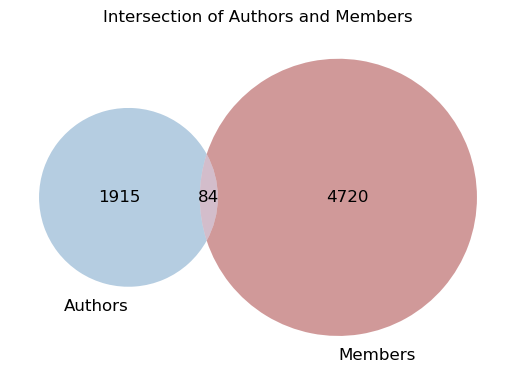

In [83]:
# Extract unique authors and members
unique_authors = set(books['author'])
unique_members = set(members['sort_name'])

# Calculate the intersection
intersection = len(unique_authors.intersection(unique_members))

# Create the Venn diagram for authors with customized colors
venn = venn2(subsets=(len(unique_authors) - intersection, len(unique_members) - intersection, intersection),
             set_labels=('Authors', 'Members'),
             set_colors=('steelblue', 'darkred'))

# Optionally, you can customize more properties, such as the transparency (alpha)
for subset in venn.subset_labels:
    if subset:  # If the subset is not None
        subset.set_fontsize(12)

plt.title('Intersection of Authors and Members')
plt.show()

In [84]:
# Calculate the percentages
percent_intersection_authors = (intersection / len(unique_authors)) * 100
percent_intersection_members = (intersection / len(unique_members)) * 100

print(f'Percent of the intersection relative to authors: {percent_intersection_authors:.2f}%')
print(f'Percent of the intersection relative to members: {percent_intersection_members:.2f}%')

Percent of the intersection relative to authors: 4.20%
Percent of the intersection relative to members: 1.75%


## Completeness

In [85]:
# Extract the rows from 'members' where 'sort_name' matches 'name' in 'member_is_author'
matched_members = members[members['sort_name'].isin(member_is_author['name'])]

# Display the resulting DataFrame which contains matched entries
matched_members.sample(3)


,uri,name,sort_name,title,gender,is_organization,has_card,birth_year,death_year,membership_years,viaf_url,wikipedia_url,nationalities,addresses,postal_codes,arrondissements,coordinates,notes,updated
349,https://shakespeareandco.princeton.edu/members...,Konrad Bercovici,"Bercovici, Konrad",Mr.,Male,False,False,1882.0,1961.0,1927,http://viaf.org/viaf/97669269/,https://en.wikipedia.org/wiki/Konrad_Bercovici,Romania;United States,"24 rue de Verneuil, Paris",75007,7,"48.85778, 2.33036","The Shakespeare and Company <a href=""https://s...",2021-07-26T01:58:27+00:00
1698,https://shakespeareandco.princeton.edu/members...,F. Scott Fitzgerald,"Fitzgerald, F. Scott",NaN,Male,False,False,1896.0,1940.0,1929,http://viaf.org/viaf/100254195/,https://en.wikipedia.org/wiki/F._Scott_Fitzgerald,United States,"3 rue Palatine, Paris",75006,6,"48.85069, 2.33522",NaN,2021-08-28T20:58:16+00:00
2593,https://shakespeareandco.princeton.edu/members...,James Joyce,"Joyce, James",NaN,Male,False,True,1882.0,1941.0,1920;1923;1924;1925;1927;1928;1929;1930;1931;1...,http://viaf.org/viaf/44300643,https://en.wikipedia.org/wiki/James_Joyce,Ireland,"6 via Cesare Battista, Trieste;9 rue de l'Univ...",34133;75007;75007;75007;75007;75007;75007;6020...,;7;7;7;7;7;7;;6;5;6;6;7;16;7;8;16;8;16;8;16;7;...,"45.65201, 13.77801;48.85665, 2.33040;48.85431,...",NaN,2020-05-14T19:51:50+00:00


In [86]:
# Function for calculating the percentage of known fields
def percent_known(df, field):
  total = len(df)
  with_field = len(df[df[field].notnull()])
  print('%d with %s : %.00f%%' % (with_field, field, (with_field/total)*100))
  return with_field

In [87]:
total_known = {}
for field in matched_members.columns:
    total_known[field] = percent_known(matched_members, field)

84 with uri : 100%
84 with name : 100%
84 with sort_name : 100%
10 with title : 12%
84 with gender : 100%
84 with is_organization : 100%
84 with has_card : 100%
82 with birth_year : 98%
80 with death_year : 95%
78 with membership_years : 93%
82 with viaf_url : 98%
75 with wikipedia_url : 89%
79 with nationalities : 94%
80 with addresses : 95%
78 with postal_codes : 93%
71 with arrondissements : 85%
77 with coordinates : 92%
15 with notes : 18%
84 with updated : 100%


In [88]:
known_members = pd.DataFrame({'total': total_known})
known_members['percent'] = (known_members['total'] / len(matched_members))*100
known_members = known_members.sort_values(by=['total'])
known_members.percent = known_members.percent.round(2)
known_members

,total,percent
title,10,11.90
notes,15,17.86
arrondissements,71,84.52
wikipedia_url,75,89.29
coordinates,77,91.67
postal_codes,78,92.86
membership_years,78,92.86
nationalities,79,94.05
addresses,80,95.24
death_year,80,95.24


<Axes: title={'center': 'Known and unknown'}>

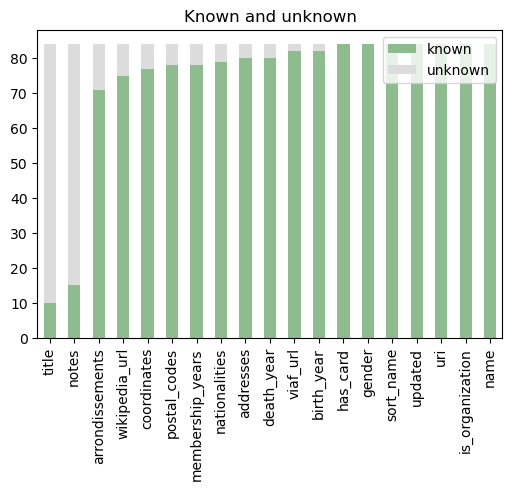

In [89]:
total_members = len(matched_members.index)
known_unknown = pd.DataFrame()
known_unknown['known'] = known_members['total']

known_unknown['unknown'] = known_members.total.apply(lambda x: total_members - x)

known_unknown.plot(kind='bar', title='Known and unknown', stacked=True, color=['darkseagreen', 'gainsboro'], figsize=(6,4))

## Coordinates

In [90]:
matched_members.sample(1)

,uri,name,sort_name,title,gender,is_organization,has_card,birth_year,death_year,membership_years,viaf_url,wikipedia_url,nationalities,addresses,postal_codes,arrondissements,coordinates,notes,updated
5013,https://shakespeareandco.princeton.edu/members...,Glenway Wescott,"Wescott, Glenway",NaN,Male,False,True,1901.0,1987.0,1925,http://viaf.org/viaf/12405830/,https://en.wikipedia.org/wiki/Glenway_Wescott,United States,"Savoy Hotel, 30 rue de Vaugirard, Paris;218 bo...",75006;75014,6;14,"48.84899, 2.33389;48.84058, 2.32972",Wescott shared a lending library membership wi...,2020-12-05T15:39:58+00:00


In [91]:
# Split the coordinates and create a new DataFrame
coordinate_list = matched_members['coordinates'].str.split(';').explode().str.strip()

# Create a DataFrame from the exploded list
coordinates_df = coordinate_list.str.split(',', expand=True)
coordinates_df.columns = ['latitude', 'longitude']

# Convert to numeric values
coordinates_df['latitude'] = pd.to_numeric(coordinates_df['latitude'])
coordinates_df['longitude'] = pd.to_numeric(coordinates_df['longitude'])

In [92]:
coordinates_df.sample(3)

,latitude,longitude
1683,NaN,NaN
1002,48.85092,2.33845
101,48.88241,2.27120


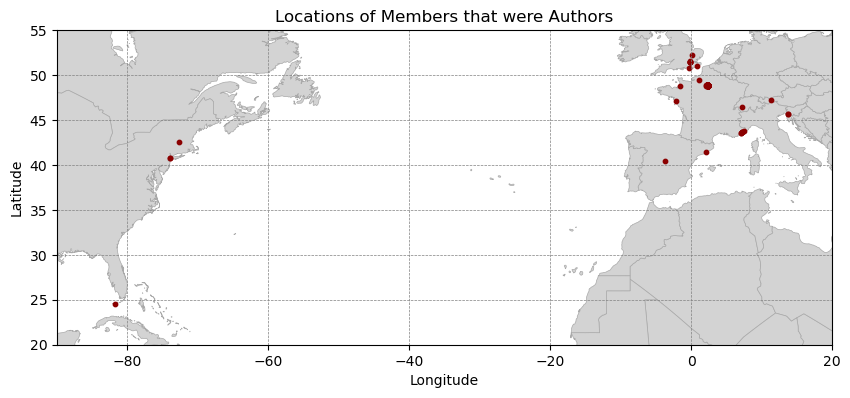

In [93]:
# Load the map of the world
world_map = gpd.read_file('../data/world.shp')

# Create a GeoDataFrame from the coordinates
gdf = gpd.GeoDataFrame(coordinates_df, geometry=gpd.points_from_xy(coordinates_df.longitude, coordinates_df.latitude))

# Set the coordinate reference system (CRS) for your GeoDataFrame
gdf.set_crs(epsg=4326, inplace=True)  # EPSG 4326 is WGS84 latitude-longitude

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

world_map.plot(ax=ax, color='lightgray', edgecolor='darkgray', linewidth=0.5) 

gdf.plot(ax=ax, marker='o', color='darkred', markersize=10)  # Plot the scatter points

# Set limits for the axes
ax.set_xlim(-90, 20)  # Set longitude bounds
ax.set_ylim(20, 55)    # Set latitude bounds

# Add a basemap
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.NatGeoWorldMap)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.DarkMatter)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title('Locations of Members that were Authors')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)


plt.show()

country Data from https://github.com/riatelab/world.git
world data from https://www.kaggle.com/datasets/venkatkumar001/geographical-data/data

## Members with same address

all members

In [94]:
# Split the addresses by semicolon and create a new DataFrame
addresses_df = members.assign(addresses=members['addresses'].str.split(';')).explode('addresses')

# Normalize and clean addresses
addresses_df['addresses'] = addresses_df['addresses'].str.strip()

# Group by addresses to find common addresses
grouped_addresses = addresses_df.groupby('addresses').agg(names=('name', ', '.join)).reset_index()

# Filter to find addresses with more than one resident
common_addresses = grouped_addresses[grouped_addresses['names'].str.contains(',')]

# Display the result
common_addresses

,addresses,names
3,"1 avenue Emile Deschanel, Paris","Paul Burt, Yva Fernandez, James Joyce"
9,"1 avenue de l'Observatoire, Paris","Mr. Chairing, Hélène de Wendel / Comtesse de N..."
15,"1 bis rue Vaneau, Paris","Polly Boyden, Henri Thomas"
16,"1 bis rue de Vaugirard, Paris","J. Duncan, Mrs. E. C. Hayes"
17,"1 boulevard Edgar Quinet, Paris","M. Lezay, Mme Lezay"
...,...,...
2113,"Victoria Palace Hotel, 6 rue Blaise Desgoffe, ...","Miss Allen, Mary Dewson, Frances Howard, Mrs. ..."
2124,"Villa Thénard, 90 chemin Gustave Raymond, Antibes","Ada (Hitchcock) MacLeish, Archibald MacLeish"
2129,"Villa le Lude, rue du Commandant Yvon, Granville","Ada (Hitchcock) MacLeish, Archibald MacLeish"
2144,"chez Mrs. Henry Michel, 3 rue Greneta, Paris","Lewis Merrick, Mr. Michel"


writer members

In [95]:
# Split the addresses by semicolon and create a new DataFrame
addresses_df = matched_members.assign(addresses=matched_members['addresses'].str.split(';')).explode('addresses')

# Normalize and clean addresses
addresses_df['addresses'] = addresses_df['addresses'].str.strip()

# Group by addresses to find common addresses
grouped_addresses = addresses_df.groupby('addresses').agg(names=('name', ', '.join)).reset_index()

# Filter to find addresses with more than one resident
common_addresses = grouped_addresses[grouped_addresses['names'].str.contains(',')]

# Display the result
common_addresses

,addresses,names
10,"12 rue de l'Odéon, Paris","George Antheil, Sylvia Beach, Padraic Colum, R..."
46,"34 rue des Vignes, Paris","Pierre de Lanux, James Joyce"
49,"4 boulevard Raspail, Paris","Stephen Vincent Benét, Margaret Wilson"
65,"6 via Cesare Battista, Trieste","James Joyce, Stanislaus Joyce"
69,"69 rue Raynouard, Paris","Élisabeth de Gramont, Duchesse de Clermont-Ton..."
75,"71 rue du Cardinal Lemoine, Paris","James Joyce, Valery Larbaud"
99,"Hotel Jacob, 44 rue Jacob, Paris","David Gascoyne, Ernest Hemingway"
142,"Select Hôtel, 1 place de la Sorbonne, Paris","Richard Aldington, Katherine Mansfield"
149,"École normale supérieure, 45 rue d'Ulm, Paris","Samuel Beckett, Thomas MacGreevy"


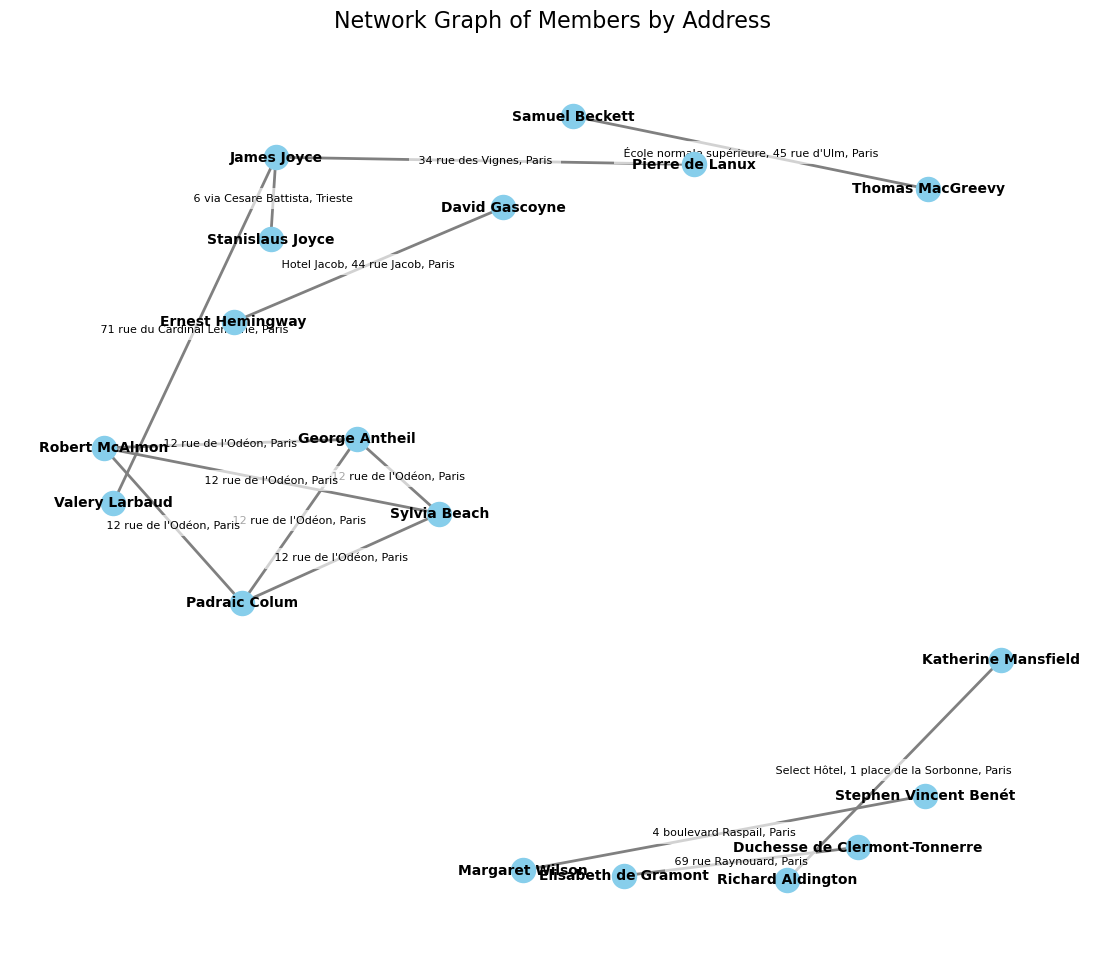

In [96]:
# Create a network graph
C = nx.Graph()

# Add edges between people who lived at the same address
for _, row in common_addresses.iterrows():
    residents = row['names'].split(', ')
    for i in range(len(residents)):
        for j in range(i + 1, len(residents)):
            C.add_edge(residents[i], residents[j], address=row['addresses'])

# Draw the graph
pos = nx.spring_layout(C, seed=42, k=0.89, iterations=40)  # Increase spacing between nodes
fig, ax = plt.subplots(figsize=(14, 12))
nx.draw(C, pos, ax=ax, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', width=2)
edge_labels = nx.get_edge_attributes(C, 'address')
formatted_edge_labels = {k: f' {v} ' for k, v in edge_labels.items()}  # Add some padding for readability
nx.draw_networkx_edge_labels(C, pos, edge_labels=formatted_edge_labels, ax=ax, font_size=8, rotate=False, bbox=dict(facecolor='white', edgecolor='none', alpha=0.65))
plt.title('Network Graph of Members by Address', size=16)
plt.show()

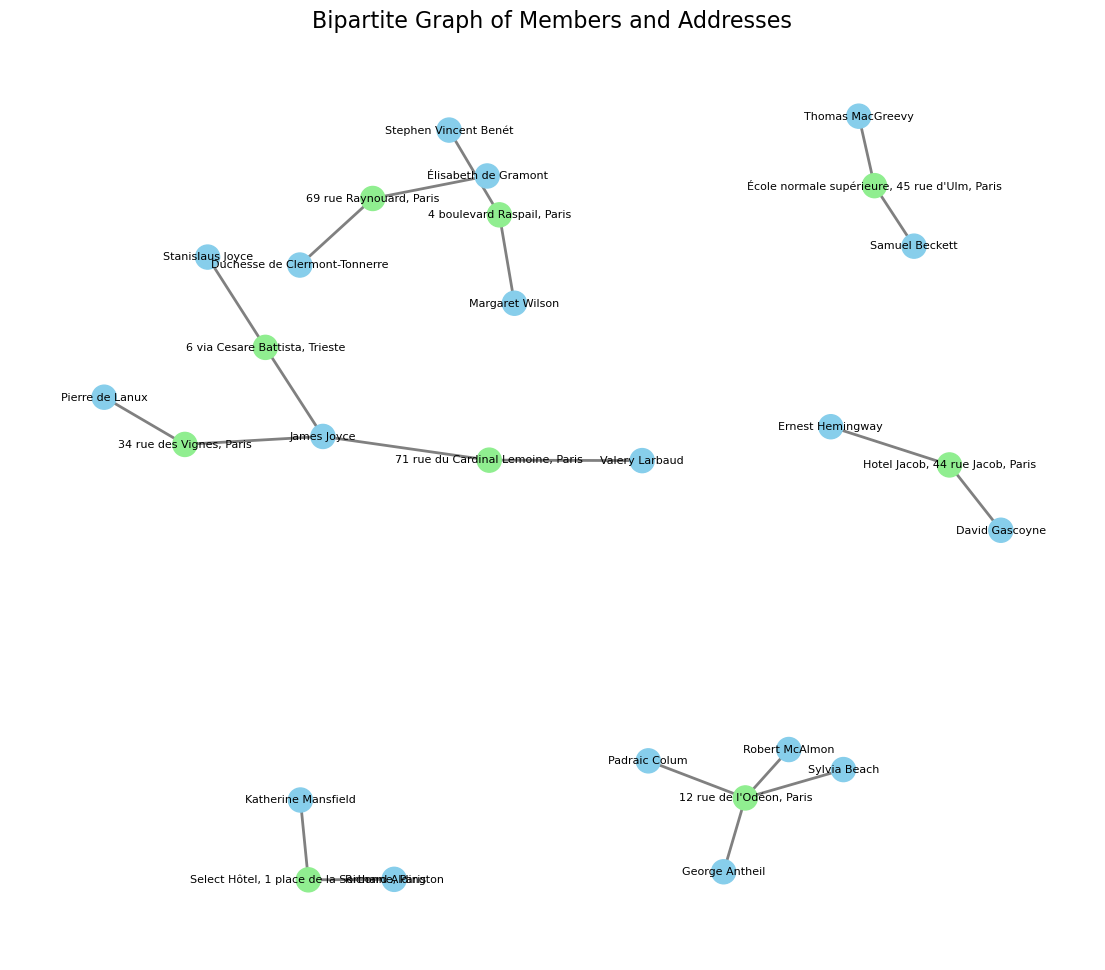

In [97]:
# Create a bipartite graph
B = nx.Graph()

# Add nodes and edges for the bipartite graph
for _, row in common_addresses.iterrows():
    address = row['addresses']
    residents = row['names'].split(', ')
    B.add_node(address, bipartite=0)  # Add address node
    for resident in residents:
        B.add_node(resident, bipartite=1)  # Add resident node
        B.add_edge(resident, address)

# Separate nodes by type for layout
people = [node for node, data in B.nodes(data=True) if data['bipartite'] == 1]
addresses = [node for node, data in B.nodes(data=True) if data['bipartite'] == 0]

# Create a bipartite layout
pos = nx.spring_layout(B, k=0.3, iterations=35)

# Draw the bipartite graph
fig, ax = plt.subplots(figsize=(14, 12))
nx.draw(B, pos, ax=ax, with_labels=True, node_size=300, 
        node_color=['skyblue' if node in people else 'lightgreen' for node in B.nodes()], 
        font_size=8, edge_color='gray', width=2)
plt.title('Bipartite Graph of Members and Addresses', size=16)
plt.show()

In [98]:
common_addresses.shape

(9, 2)

## Nationalities

In [99]:
matched_members.nationalities.sample(20)

544            United States
308           France;Ireland
2800                  France
2195                     NaN
83             United States
2006                     NaN
2665             Netherlands
2884          United Kingdom
3872           United States
736                   Canada
4674           United States
3383          Belgium;France
3428           United States
3741           United States
936                  Ireland
122     Poland;United States
231     France;United States
4281                  France
1012          United Kingdom
2427          United Kingdom
Name: nationalities, dtype: object

In [100]:
# Handling NaN
matched_members['nationalities'] = matched_members['nationalities'].fillna('Unknown')

# Splitting multiple nationalities
# This will create a new row for each nationality in cases where there are multiple nationalities separated by ';'
df = matched_members.drop('nationalities', axis=1).join(
    matched_members['nationalities'].str.split(';', expand=True).stack().reset_index(level=1, drop=True).rename('nationalities')
)

print(df)

                                                    uri                  name  \
45    https://shakespeareandco.princeton.edu/members...     Richard Aldington   
83    https://shakespeareandco.princeton.edu/members...  Margaret C. Anderson   
94    https://shakespeareandco.princeton.edu/members...        George Antheil   
101   https://shakespeareandco.princeton.edu/members...          Louis Aragon   
122   https://shakespeareandco.princeton.edu/members...           Nathan Asch   
...                                                 ...                   ...   
5050  https://shakespeareandco.princeton.edu/members...          Anna Wickham   
5057  https://shakespeareandco.princeton.edu/members...       Thornton Wilder   
5098  https://shakespeareandco.princeton.edu/members...       Margaret Wilson   
5109  https://shakespeareandco.princeton.edu/members...          Romer Wilson   
5180  https://shakespeareandco.princeton.edu/members...        Richard Wright   

                  sort_name

C:\Users\dittm\AppData\Local\Temp\ipykernel_4196\3917217080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_members['nationalities'] = matched_members['nationalities'].fillna('Unknown')


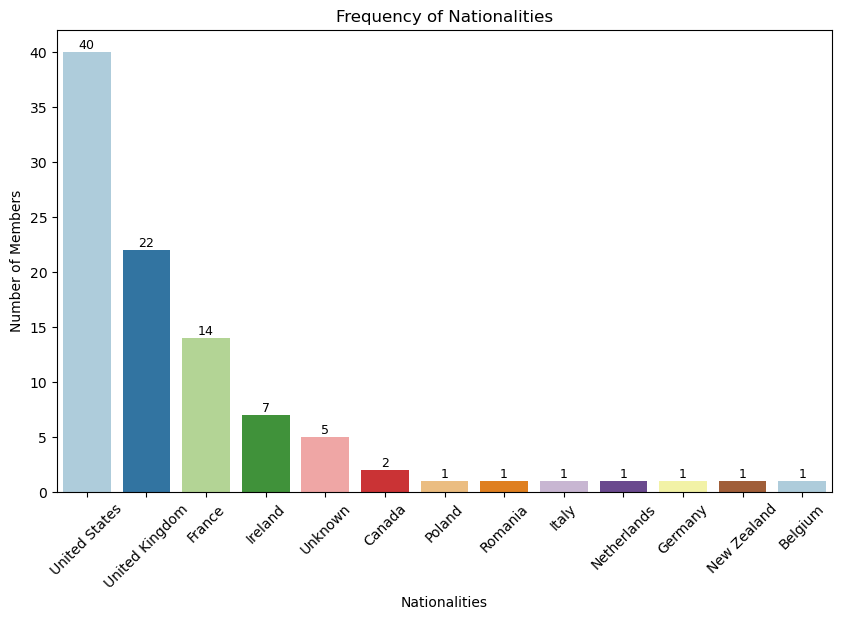

In [101]:
nationality_counts = df['nationalities'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=nationality_counts.index, y=nationality_counts.values, palette='Paired')
plt.title('Frequency of Nationalities')
plt.xlabel('Nationalities')
plt.ylabel('Number of Members')
plt.xticks(rotation=45)
for i, count in enumerate(nationality_counts.values):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=9)
plt.show()


In [102]:
percentages = df['nationalities'].value_counts(normalize=True) * 100
print(percentages)

United States     41.237113
United Kingdom    22.680412
France            14.432990
Ireland            7.216495
Unknown            5.154639
Canada             2.061856
Poland             1.030928
Romania            1.030928
Italy              1.030928
Netherlands        1.030928
Germany            1.030928
New Zealand        1.030928
Belgium            1.030928
Name: nationalities, dtype: float64


### Mode

In [103]:
mode_nationalities = df['nationalities'].value_counts().idxmax() # mode
print(f"Mode of nationalities distribution: {mode_nationalities}")

Mode of nationalities distribution: United States


### Entropy

In [104]:
# Assuming `members` DataFrame and 'gender' column exist
nationalities_counts = df['nationalities'].value_counts(normalize=True)
entropy_nationalities = entropy(nationalities_counts)

# Calculate the number of unique categories (genders)
num_categories = nationalities_counts.size

# Calculate the maximum possible entropy
max_entropy = np.log(num_categories)

# Print the entropy and the benchmark
print(f"Entropy of nationalities distribution: {entropy_nationalities}")
print(f"Maximum possible entropy with {num_categories} categories: {max_entropy}")

# Calculate the normalized entropy (entropy divided by maximum possible entropy)
normalized_entropy = entropy_nationalities / max_entropy

print(f"Normalized entropy: {normalized_entropy}")

Entropy of nationalities distribution: 1.7338886102587268
Maximum possible entropy with 13 categories: 2.5649493574615367
Normalized entropy: 0.6759933116085812


## Gender

In [105]:
count_gender = matched_members['gender'].value_counts().sort_index()  # operate on series ; count

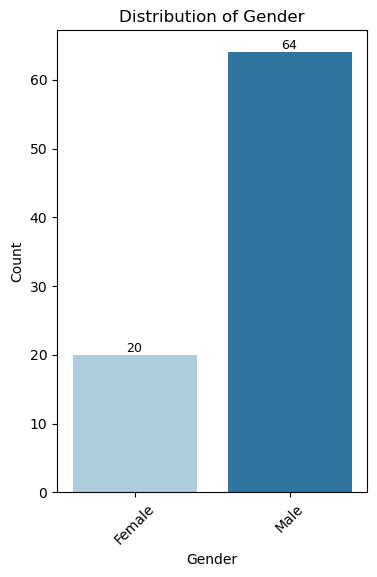

In [106]:
plt.figure(figsize=(4, 6))
ax = sns.barplot(x=count_gender.index, y=count_gender.values, palette='Paired')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, count in enumerate(count_gender.values):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=9)

plt.show()

In [107]:
percentages = matched_members['gender'].value_counts(normalize=True) * 100
print(percentages)

Male      76.190476
Female    23.809524
Name: gender, dtype: float64


### Mode

In [108]:
mode_gender = matched_members['gender'].value_counts().idxmax() # mode
print(f"Mode of gender distribution: {mode_gender}")

Mode of gender distribution: Male


### Entropy

In [109]:
# Assuming `members` DataFrame and 'gender' column exist
gender_counts = matched_members['gender'].value_counts(normalize=True)
entropy_gender = entropy(gender_counts)

# Calculate the number of unique categories (genders)
num_categories = gender_counts.size

# Calculate the maximum possible entropy
max_entropy = np.log(num_categories)

# Print the entropy and the benchmark
print(f"Entropy of gender distribution: {entropy_gender}")
print(f"Maximum possible entropy with {num_categories} categories: {max_entropy}")

# Calculate the normalized entropy (entropy divided by maximum possible entropy)
normalized_entropy = entropy_gender / max_entropy

print(f"Normalized entropy: {normalized_entropy}")

Entropy of gender distribution: 0.5488743844849944
Maximum possible entropy with 2 categories: 0.6931471805599453
Normalized entropy: 0.7918583525674836


## Age

C:\Users\dittm\AppData\Local\Temp\ipykernel_4196\1030809175.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['birth_year'] = df['birth_year'].astype(int)


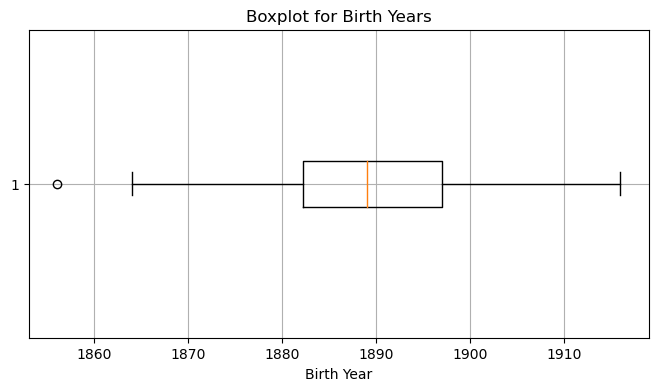

In [110]:
# Cleaning: Remove NaN values
df = matched_members.dropna(subset=['birth_year'])

# Convert birth_year to integer
df['birth_year'] = df['birth_year'].astype(int)

# Plotting a boxplot
plt.figure(figsize=(8, 4))
plt.boxplot(df['birth_year'], vert=False)  # 'vert=False' makes the boxplot horizontal
plt.title('Boxplot for Birth Years')
plt.xlabel('Birth Year')
plt.grid(True)
plt.show()

In [111]:
# Group birth years into bins (e.g., by decade)
matched_members['birth_year_group'] = pd.cut(matched_members['birth_year'], bins=np.arange(1850, 1920, 10))

# Calculate the normalized value counts for each bin
birth_year_group_counts = matched_members['birth_year_group'].value_counts(normalize=True)

# Calculate the entropy of the birth year distribution
entropy_birth_year = entropy(birth_year_group_counts)

# Calculate the number of unique bins
num_bins = birth_year_group_counts.size

# Calculate the maximum possible entropy
max_entropy = np.log(num_bins)

# Calculate the normalized entropy
normalized_entropy = entropy_birth_year / max_entropy

# Print the results
print(f"Entropy of birth year distribution: {entropy_birth_year}")
print(f"Maximum possible entropy with {num_bins} bins: {max_entropy}")
print(f"Normalized entropy: {normalized_entropy}")


Entropy of birth year distribution: 1.4401361309075074
Maximum possible entropy with 6 bins: 1.791759469228055
Normalized entropy: 0.803755278339878


C:\Users\dittm\AppData\Local\Temp\ipykernel_4196\827458227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_members['birth_year_group'] = pd.cut(matched_members['birth_year'], bins=np.arange(1850, 1920, 10))


In [112]:
print(matched_members['birth_year'].mean())
print(matched_members['birth_year'].median())
print(matched_members['birth_year'].mode())

1888.8658536585365
1889.0
0    1883.0
1    1888.0
2    1892.0
3    1899.0
Name: birth_year, dtype: float64


!! multimodal !!

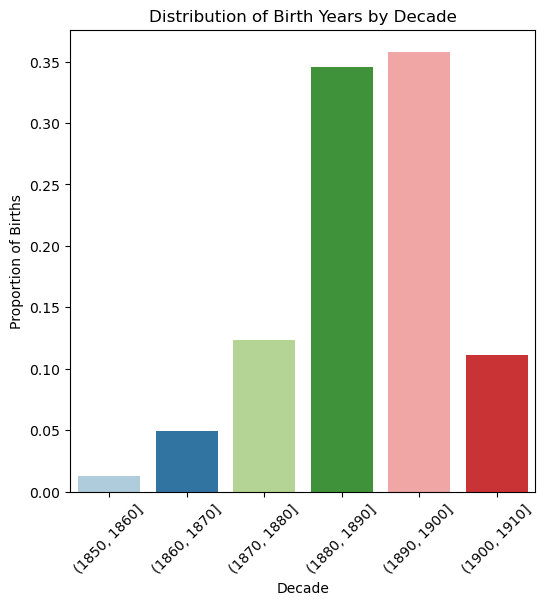

In [113]:
plt.figure(figsize=(6, 6))
ax = sns.barplot(x=birth_year_group_counts.index, y=birth_year_group_counts.values, palette='Paired')
plt.xlabel('Decade')
plt.ylabel('Proportion of Births')
plt.title('Distribution of Birth Years by Decade')
plt.xticks(rotation=45)

plt.show()

In [114]:
# Calculate the percentage for each birth year group
birth_year_group_percentages = birth_year_group_counts * 100

# Sort by decade for better readability
birth_year_group_percentages = birth_year_group_percentages.sort_index()

# Display the percentages in plain text
for decade, percentage in birth_year_group_percentages.items():
    print(f"{decade}: {percentage:.2f}%")


(1850, 1860]: 1.23%
(1860, 1870]: 4.94%
(1870, 1880]: 12.35%
(1880, 1890]: 34.57%
(1890, 1900]: 35.80%
(1900, 1910]: 11.11%


## Books per member that is author

In [115]:
member_is_author.sample(5)

,name
4,"Asch, Nathan"
44,"Huddleston, Sisley"
15,"Briffault, Robert"
46,"Josephson, Matthew"
32,"Flandrau, Grace"


### Overall comparison of books by members

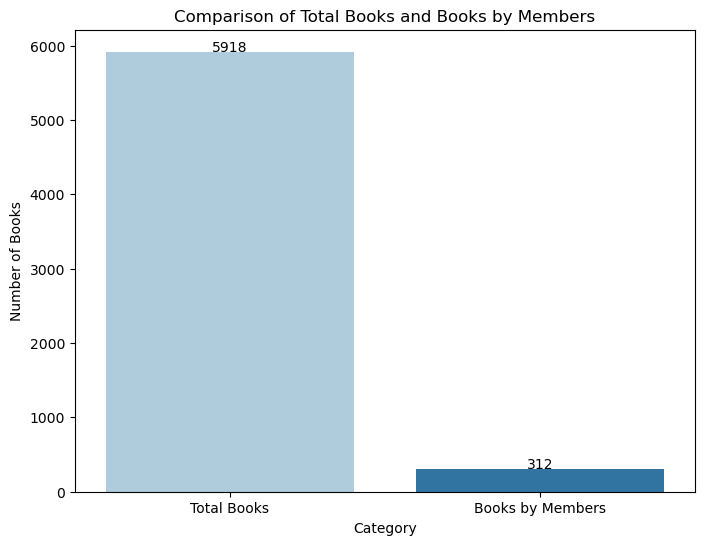

In [116]:
books_by_member = books[books['author'].isin(member_is_author['name'])]

# Filter books to only include those published until 1941
#books_until_1941 = books[books['year'] <= 1941]
#books_by_member_until_1941 = books_by_member[books_by_member['year'] <= 1941]

# Calculate the number of unique titles (assuming no duplicates in the original dataset)
total_unique_titles = len(books['title'].unique())
unique_titles_by_member = len(books_by_member['title'].unique())

# Prepare data for plotting
data = pd.DataFrame({
    'Category': ['Total Books', 'Books by Members'],
    'Count': [total_unique_titles, unique_titles_by_member]
})

# Plot the diagram
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Category', y='Count', data=data, palette='Paired')
for index, row in data.iterrows():
    barplot.text(index, row.Count, round(row.Count, 2), color='black', ha="center")
plt.ylabel('Number of Books')
plt.title('Comparison of Total Books and Books by Members')
plt.show()

In [117]:
# Calculate the percentage of unique titles by members out of the total
percentage_of_books_by_members = (unique_titles_by_member / total_unique_titles) * 100

# Prepare a dictionary with the results
book_counts_summary = {
    'Total Books': total_unique_titles,
    'Books by Members': unique_titles_by_member,
    'Percentage of Books by Members': f'{percentage_of_books_by_members:.2f}%'
}

# Display the dictionary
book_counts_summary

{'Total Books': 5918,
 'Books by Members': 312,
 'Percentage of Books by Members': '5.27%'}

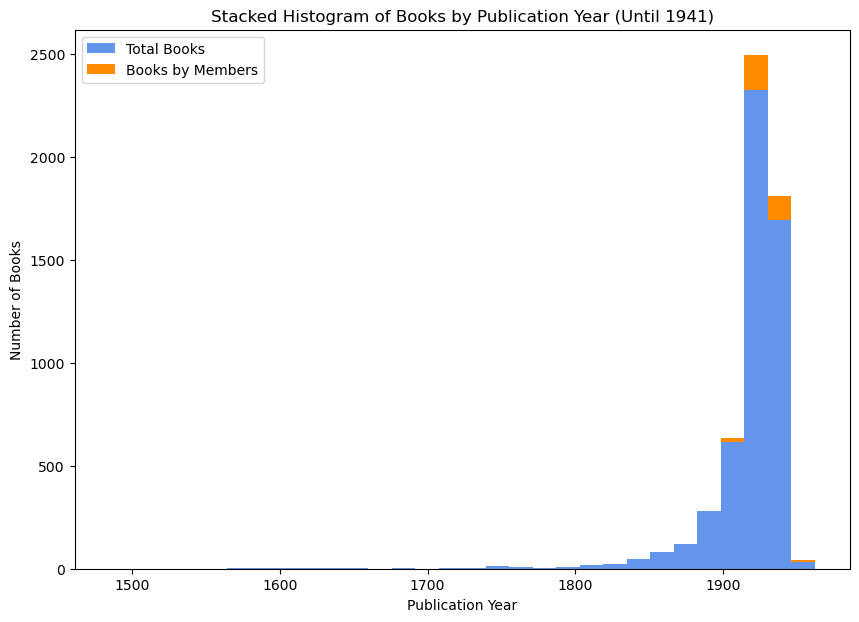

In [118]:
# Filter the books dataframe to keep only the rows where the author is in the list of authors who are members
books_by_member = books[books['author'].isin(member_is_author['name'])]

# Drop rows with missing values in the 'year' column for both datasets
books = books.dropna(subset=['year'])
books_by_member = books_by_member.dropna(subset=['year'])

# Convert 'year' to integer (or the appropriate type if not already)
books['year'] = books['year'].astype(int)
books_by_member['year'] = books_by_member['year'].astype(int)

# Filter books to only include those published until 1941
#books_until_1941 = books[books['year'] <= 1941]
#books_by_member_until_1941 = books_by_member[books_by_member['year'] <= 1941]

# Prepare data for plotting
all_books = books['year']
member_books = books_by_member['year']

# Plot the stacked histogram
plt.figure(figsize=(10, 7))
plt.hist([all_books, member_books], bins=30, stacked=True, label=['Total Books', 'Books by Members'], color=['cornflowerblue', 'darkorange'])
plt.xlabel('Publication Year')
plt.ylabel('Number of Books')
plt.title('Stacked Histogram of Books by Publication Year (Until 1941)')
plt.legend()
plt.show()

!! find latest publication year

In [119]:
bin_edges = np.linspace(min(all_books.min(), member_books.min()), 1962, 31)  # Create 30 bins from min year to 1941
all_books_counts, _ = np.histogram(all_books, bins=bin_edges)
member_books_counts, _ = np.histogram(member_books, bins=bin_edges)

# Output the bin edges and counts
for i, edge in enumerate(bin_edges[:-1]):
    print(f"From {int(edge)} to {int(bin_edges[i+1])} - Total Books: {all_books_counts[i]}, Books by Members: {member_books_counts[i]}")

From 1485 to 1500 - Total Books: 1, Books by Members: 0
From 1500 to 1516 - Total Books: 1, Books by Members: 0
From 1516 to 1532 - Total Books: 0, Books by Members: 0
From 1532 to 1548 - Total Books: 0, Books by Members: 0
From 1548 to 1564 - Total Books: 1, Books by Members: 0
From 1564 to 1580 - Total Books: 2, Books by Members: 0
From 1580 to 1596 - Total Books: 4, Books by Members: 0
From 1596 to 1612 - Total Books: 3, Books by Members: 0
From 1612 to 1628 - Total Books: 2, Books by Members: 0
From 1628 to 1644 - Total Books: 2, Books by Members: 0
From 1644 to 1659 - Total Books: 3, Books by Members: 0
From 1659 to 1675 - Total Books: 1, Books by Members: 0
From 1675 to 1691 - Total Books: 2, Books by Members: 0
From 1691 to 1707 - Total Books: 1, Books by Members: 0
From 1707 to 1723 - Total Books: 5, Books by Members: 0
From 1723 to 1739 - Total Books: 4, Books by Members: 0
From 1739 to 1755 - Total Books: 12, Books by Members: 0
From 1755 to 1771 - Total Books: 9, Books by Me

### How many books does each author have?

In [120]:
# Group the dataframe by 'author' and count the number of titles for each author
books_count_by_author = books_by_member.groupby('author').count()['title'].sort_values(ascending=False)

# Optionally, you might want to reset the index to make the data more presentable
books_count_by_author = books_count_by_author.reset_index()
books_count_by_author.columns = ['Author', 'Number of Books']

# Display the result
print(books_count_by_author)

                      Author  Number of Books
0           Ford, Ford Madox               18
1                Pound, Ezra               16
2               Joyce, James               12
3           Bromfield, Louis               11
4            Stein, Gertrude               11
..                       ...              ...
79        Bishop, John Peale                1
80             Beach, Sylvia                1
81  Barney, Natalie Clifford                1
82            McKenney, Ruth                1
83          de Lanux, Pierre                1

[84 rows x 2 columns]


In [121]:
books_by_member

,uri,title,author,editor,translator,introduction,illustrator,photographer,year,format,uncertain,ebook_url,volumes_issues,notes,event_count,borrow_count,purchase_count,circulation_years,updated
583,https://shakespeareandco.princeton.edu/books/g...,Les Nourritures Terrestres,"Gide, André",NaN,NaN,NaN,NaN,NaN,1897,Book,False,https://archive.org/details/lesnourritureste00...,NaN,NaN,1,0,1,1938,2021-11-12T12:47:36.686932+00:00
618,https://shakespeareandco.princeton.edu/books/m...,The Actor Manager,"Merrick, Leonard",NaN,NaN,NaN,NaN,NaN,1898,Book,False,https://archive.org/details/actormanager00merr...,NaN,NaN,1,1,0,1922,2021-01-17T22:01:25+00:00
717,https://shakespeareandco.princeton.edu/books/g...,The Immoralist,"Gide, André",NaN,NaN,NaN,NaN,NaN,1902,Book,False,NaN,NaN,NaN,2,2,0,1936;1935,2020-06-29T15:35:11+00:00
731,https://shakespeareandco.princeton.edu/books/m...,Conrad in Quest of His Youth,"Merrick, Leonard",NaN,NaN,NaN,NaN,NaN,1903,Book,False,https://archive.org/details/conradinquestofh00...,NaN,NaN,2,2,0,1921;1923,2021-04-18T18:52:08+00:00
807,https://shakespeareandco.princeton.edu/books/m...,Sidney Lanier,"Mims, Edwin",NaN,NaN,NaN,NaN,NaN,1905,Book,False,https://archive.org/details/sidneylanier00mims_0,NaN,NaN,1,1,0,1936,2021-11-06T01:46:44.326445+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5281,https://shakespeareandco.princeton.edu/books/b...,The Player's Boy,Bryher,NaN,NaN,NaN,NaN,NaN,1953,Book,False,NaN,NaN,NaN,1,1,0,1953,2020-04-30T19:40:16+00:00
5289,https://shakespeareandco.princeton.edu/books/m...,L'Infini turbulent,"Michaux, Henri",NaN,NaN,NaN,NaN,NaN,1957,Book,False,NaN,NaN,NaN,1,0,0,1957,2020-06-26T20:18:00+00:00
5293,https://shakespeareandco.princeton.edu/books/j...,My Brother's Keeper: James Joyce's Early Years,"Joyce, Stanislaus",NaN,NaN,"Eliot, T. S.;Ellmann, Richard",NaN,NaN,1958,Book,False,NaN,NaN,NaN,1,1,0,1960;1958,2021-07-26T19:27:12+00:00
5296,https://shakespeareandco.princeton.edu/books/b...,Shakespeare and Company,"Beach, Sylvia",NaN,NaN,NaN,NaN,NaN,1959,Book,False,NaN,NaN,NaN,2,2,0,1961,2020-04-30T19:40:21+00:00


In [122]:
books_count_by_author.sample(5)

,Author,Number of Books
20,"Eastman, Max",5
77,"Josephson, Matthew",1
51,"Cowley, Malcolm",2
25,"Wilson, Romer",4
52,"Solano, Solita",2


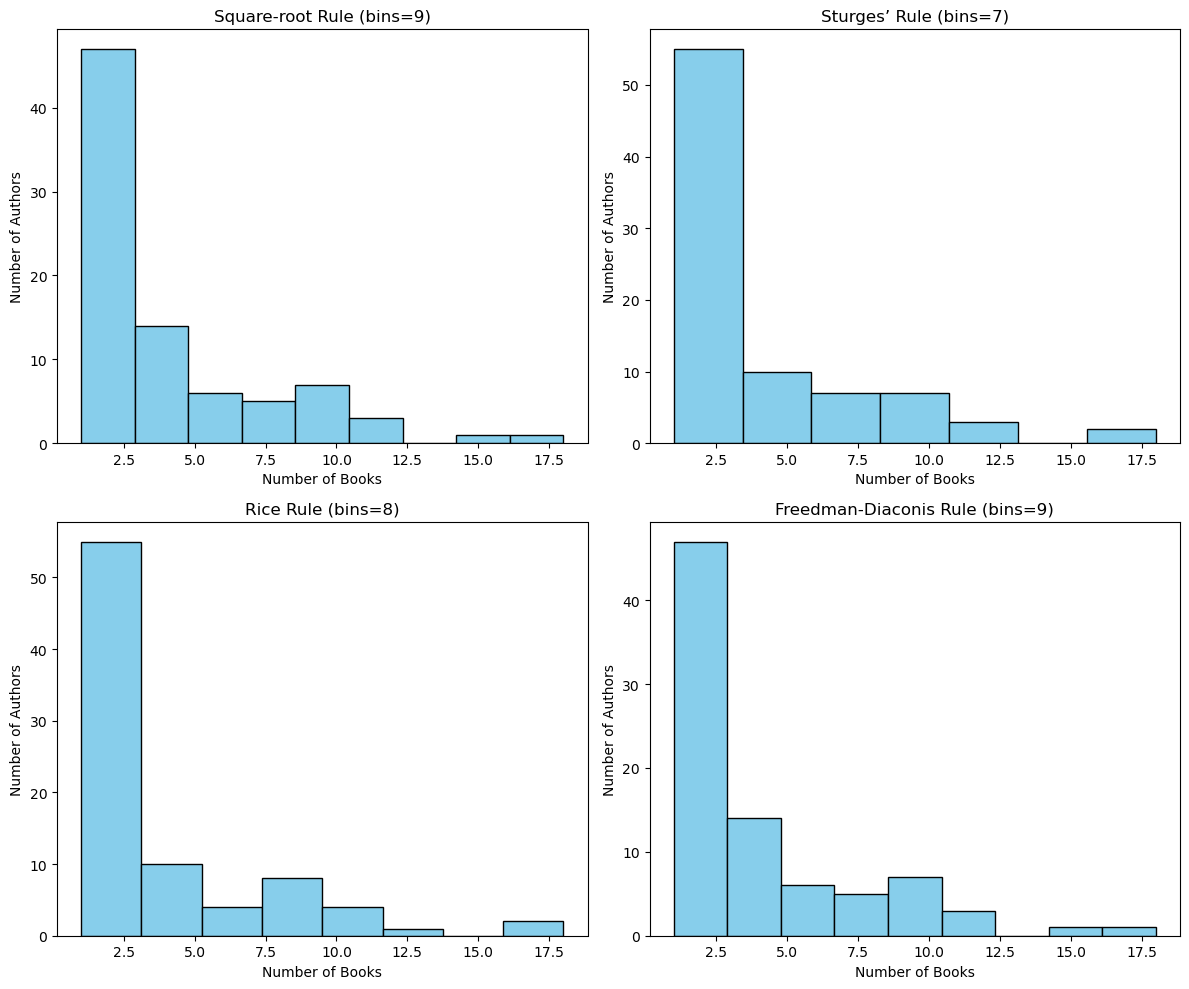

In [123]:
number_of_books = books_count_by_author['Number of Books'].values
n = len(number_of_books)

# Calculating bin numbers
sqrt_bins = int(np.sqrt(n))
sturges_bins = int(np.log2(n)) + 1
rice_bins = int(2 * (n ** (1/3)))
iqr = np.percentile(number_of_books, 75) - np.percentile(number_of_books, 25)
fd_bins = int(np.ptp(number_of_books) / (2 * (iqr / (n ** (1/3)))))

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

# Square-root Rule
axs[0].hist(number_of_books, bins=sqrt_bins, color='skyblue', edgecolor='black')
axs[0].set_title(f'Square-root Rule (bins={sqrt_bins})')
axs[0].set_xlabel('Number of Books')
axs[0].set_ylabel('Number of Authors')

# Sturges' Rule
axs[1].hist(number_of_books, bins=sturges_bins, color='skyblue', edgecolor='black')
axs[1].set_title(f'Sturges’ Rule (bins={sturges_bins})')
axs[1].set_xlabel('Number of Books')
axs[1].set_ylabel('Number of Authors')

# Rice Rule
axs[2].hist(number_of_books, bins=rice_bins, color='skyblue', edgecolor='black')
axs[2].set_title(f'Rice Rule (bins={rice_bins})')
axs[2].set_xlabel('Number of Books')
axs[2].set_ylabel('Number of Authors')

# Freedman-Diaconis Rule
axs[3].hist(number_of_books, bins=fd_bins, color='skyblue', edgecolor='black')
axs[3].set_title(f'Freedman-Diaconis Rule (bins={fd_bins})')
axs[3].set_xlabel('Number of Books')
axs[3].set_ylabel('Number of Authors')

plt.tight_layout()
plt.show()


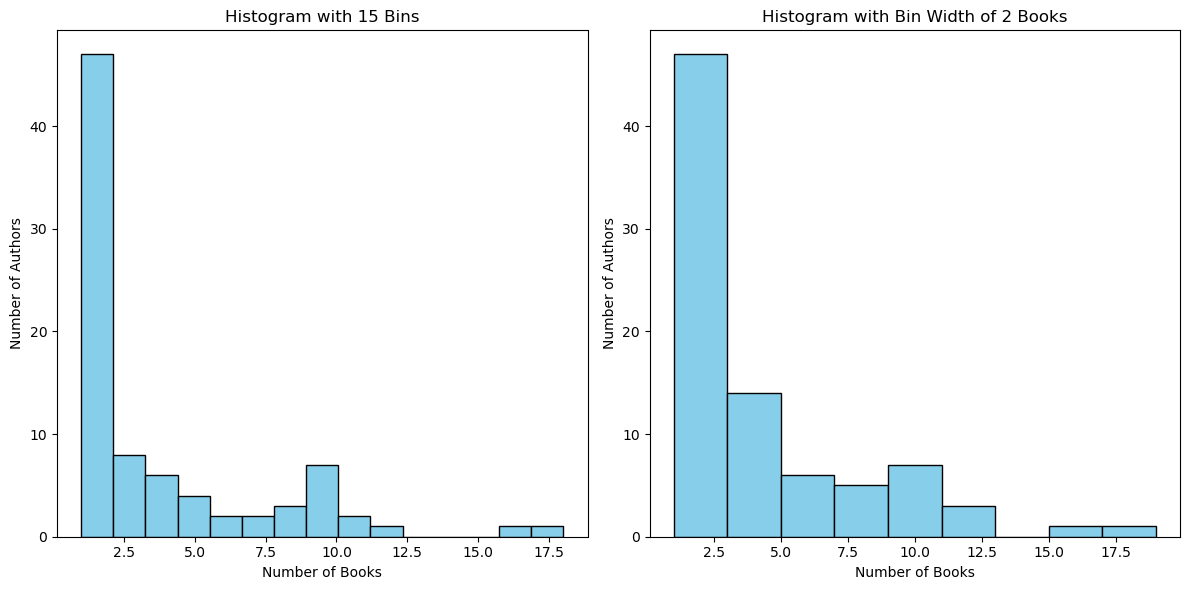

In [124]:
# Manually specifying the number of bins
num_bins = 15  # Change this number to adjust bin count

# Setting a specific bin width
bin_width = 2  # Each bin will cover a range of 5 books
bin_range = (np.min(number_of_books), np.max(number_of_books))
bins = np.arange(bin_range[0], bin_range[1] + bin_width, bin_width)  # create bin edges

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram with specified number of bins
plt.subplot(1, 2, 1)
plt.hist(number_of_books, bins=num_bins, color='skyblue', edgecolor='black')
plt.title(f'Histogram with {num_bins} Bins')
plt.xlabel('Number of Books')
plt.ylabel('Number of Authors')

# Histogram with specific bin width
plt.subplot(1, 2, 2)
plt.hist(number_of_books, bins=bins, color='skyblue', edgecolor='black')
plt.title(f'Histogram with Bin Width of {bin_width} Books')
plt.xlabel('Number of Books')
plt.ylabel('Number of Authors')

plt.tight_layout()
plt.show()

In [125]:
highest_books_count = books_count_by_author.nlargest(20, 'Number of Books')

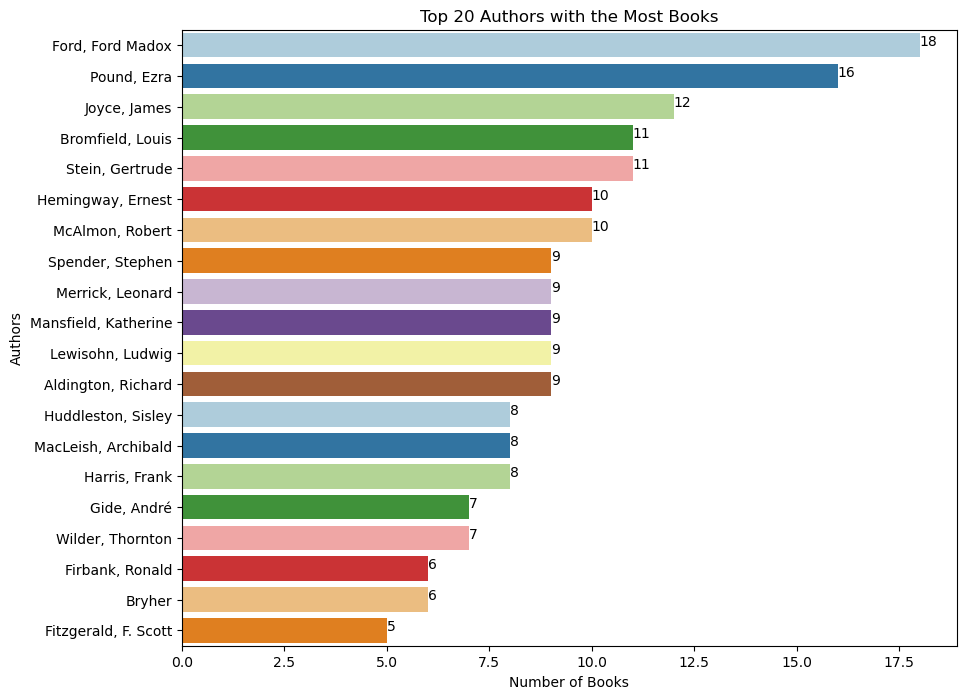

In [126]:
# Create the plot
plt.figure(figsize=(10, 8))  # Set the figure size
sns.barplot(x='Number of Books', y='Author', data=highest_books_count, palette='Paired')

# Add labels and title
plt.xlabel('Number of Books')
plt.ylabel('Authors')
plt.title('Top 20 Authors with the Most Books')

# Optional: Add values on the bars for better readability
for index, value in enumerate(highest_books_count['Number of Books']):
    plt.text(value, index, str(value))  # Display the count next to the bars

plt.show()

## Borrow comparisons

In [127]:
books_by_member_events = events[events['item_authors'].isin(member_is_author['name'])]

In [128]:
borrow_by_author = books_by_member_events[books_by_member_events['event_type'] == 'Borrow']
borrow_by_author.shape

(1539, 28)

In [129]:
borrow_by_author['event_type'].unique()

array(['Borrow'], dtype=object)

In [130]:
borrow_by_author = borrow_by_author[borrow_by_author['member_sort_names'].isin(member_is_author['name'])]
borrow_by_author.event_type.unique()

array(['Borrow'], dtype=object)

In [131]:
borrow_by_author.member_sort_names.unique()

array(['Joyce, James', 'Hemingway, Ernest', 'Beach, Sylvia',
       'Wilson, Romer', 'Aragon, Louis', 'Stein, Gertrude',
       'Rodker, John', 'Mansfield, Katherine', 'Solano, Solita',
       'de Lanux, Pierre', 'Wickham, Anna', 'Le Gallienne, Richard',
       'Gilbert, Stuart', 'Porter, Katherine Anne', 'Connolly, Cyril',
       'Gascoyne, David', 'Dennis, Mary Cable', 'Merrick, Leonard',
       'Rogers, Samuel', 'Ford, Ford Madox', 'Paul, Elliot'], dtype=object)

In [132]:
valery_mem = borrow_by_author[borrow_by_author['member_sort_names'] == 'Larbaud, Valery']
valery_mem

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,item_uri,item_title,item_volume,item_authors,item_year,item_notes,source_type,source_citation,source_manifest,source_image


In [133]:
books_event = events[events['event_type'] == 'Borrow']
books_event.shape

(21059, 28)

In [134]:
books_event = books_event[books_event['member_sort_names'].isin(member_is_author['name'])]
books_event.shape

(877, 28)

In [135]:
books_event.member_sort_names.unique()

array(['Joyce, James', 'Hemingway, Ernest', 'Schlumberger, Jean',
       'Beach, Sylvia', 'Stein, Gertrude', 'Larbaud, Valery',
       'McAlmon, Robert', 'Wilson, Romer', 'Aragon, Louis',
       'Rodker, John', 'Wilder, Thornton', 'Pound, Ezra',
       'Mansfield, Katherine', 'Solano, Solita', 'de Lanux, Pierre',
       'Tree, Iris', 'Wickham, Anna', 'Wilson, Margaret',
       'Le Gallienne, Richard', 'Gilbert, Stuart', 'Boyd, James',
       'Flandrau, Grace', 'Porter, Katherine Anne', 'Lewisohn, Ludwig',
       'Tate, Allen', 'Gascoyne, David', 'Connolly, Cyril',
       'Merrick, Leonard', 'Dennis, Mary Cable', 'Rogers, Samuel',
       'Guilloux, Louis', 'Gramont, Élisabeth de', 'Ford, Ford Madox',
       'Paul, Elliot', 'Michaux, Henri', 'Wright, Richard', 'Gide, André'],
      dtype=object)

In [136]:
valery = books_event[books_event['member_sort_names'] == 'Larbaud, Valery']
valery

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,item_uri,item_title,item_volume,item_authors,item_year,item_notes,source_type,source_citation,source_manifest,source_image
615,Borrow,--01-29,--02-01,https://shakespeareandco.princeton.edu/members...,Valery Larbaud,"Larbaud, Valery",NaN,NaN,NaN,NaN,...,https://shakespeareandco.princeton.edu/books/j...,The Turn of the Screw,NaN,"James, Henry",1898.0,NaN,Lending Library Card,"Sylvia Beach, Valery Larbaud Lending Library C...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/a6...


In [137]:
books_event['event_type'].unique()

array(['Borrow'], dtype=object)

In [138]:
# Create a pivot table with users as rows, books as columns, and counts of borrow events as values
user_book_matrix_all = books_event.pivot_table(index='member_sort_names', columns='item_title', aggfunc='size', fill_value=0)

print(user_book_matrix_all.tail(2))

item_title         A Bookman's Daybook  A Companion Volume  \
member_sort_names                                            
Wright, Richard                      0                   0   
de Lanux, Pierre                     0                   2   

item_title         A Concise History of Ireland  \
member_sort_names                                 
Wright, Richard                               0   
de Lanux, Pierre                              0   

item_title         A Dark Lantern: A Story with a Prologue  \
member_sort_names                                            
Wright, Richard                                          0   
de Lanux, Pierre                                         0   

item_title         A Farewell to Arms  A Foregone Conclusion  A Gallery  \
member_sort_names                                                         
Wright, Richard                     0                      0          0   
de Lanux, Pierre                    0                      0          0 

In [140]:
# Create a pivot table with users as rows, books as columns, and counts of borrow events as values
user_book_matrix = borrow_member_events_by_author.pivot_table(index='member_sort_names', columns='item_title', aggfunc='size', fill_value=0)

print(user_book_matrix.tail(2))

item_title         A Companion Volume  A Farewell to Arms  A Good Woman  \
member_sort_names                                                         
Wilson, Romer                       0                   0             0   
de Lanux, Pierre                    2                   0             0   

item_title         A Hasty Bunch  A Mirror to France  A Modern Hero  \
member_sort_names                                                     
Wilson, Romer                  0                   0              0   
de Lanux, Pierre               1                   0              0   

item_title         A Portrait of the Artist as a Young Man  \
member_sort_names                                            
Wilson, Romer                                            1   
de Lanux, Pierre                                         0   

item_title         A. O. Barnabooth: His Diary  \
member_sort_names                                
Wilson, Romer                                0   
de Lanux, Pierr

In [141]:
# Sum the borrow counts across all users to get the total borrow count for each book
borrow_counts = user_book_matrix.sum(axis=0).reset_index()
borrow_counts.columns = ['book_title', 'borrow_count']

# Display the top 10 most borrowed books as a sanity check
print(borrow_counts.sort_values(by='borrow_count', ascending=False).head(15))

                                           book_title  borrow_count
6             A Portrait of the Artist as a Young Man             4
0                                  A Companion Volume             3
35               The Autobiography of Alice B. Toklas             3
47                                        Three Lives             3
4                                  A Mirror to France             2
49  To Return to Yesterday: Reminiscences 1894 – 1914             2
8   Back to Montparnasse: Glimpses of Broadway in ...             2
28              Oscar Wilde: His Life and Confessions             2
11                             Death in the Afternoon             2
12                Distinguished Air: Grim Fairy Tales             2
46                              This Side of Paradise             2
31                                 Strait Is the Gate             2
37                                 The Counterfeiters             2
17                                Geography and 

In [142]:
print(borrow_counts.sort_values(by='borrow_count', ascending=False).shape)

(54, 2)


In [ ]:
# Sum the borrow counts across all users to get the total borrow count for each book
borrow_counts_all = user_book_matrix_all.sum(axis=0).reset_index()
borrow_counts_all.columns = ['book_title', 'borrow_count']

# Display the top 10 most borrowed books as a sanity check
print(borrow_counts_all.sort_values(by='borrow_count', ascending=False).head(15))

                                            book_title  borrow_count
378                      Saturday Review of Literature             9
733                                         transition             8
688                          Thomas De Quincey's Works             6
210                                       Hound & Horn             4
99                                               Broom             4
486                                           The Dial             4
307                                         New Masses             4
32             A Portrait of the Artist as a Young Man             4
639                   The Symposium: A Critical Review             3
676  The Works of Sterne: The Life and Opinions of ...             3
583                                   The New Republic             3
61                                        And Even Now             3
236                            Lady Chatterley's Lover             3
432               The Autobiograph

In [ ]:
borrow_counts.shape

(734, 2)

In [ ]:
# Create an empty graph
G = nx.Graph()

# Add nodes and edges based on the user-book matrix
for user1 in user_book_matrix.index:
    for user2 in user_book_matrix.index:
        if user1 != user2:
            # Calculate intersection of books borrowed by both users
            common_books = sum((user_book_matrix.loc[user1] > 0) & (user_book_matrix.loc[user2] > 0))
            if common_books > 0:
                G.add_edge(user1, user2, weight=common_books)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 18
Number of edges: 31


In [ ]:
# Create an empty graph
L = nx.Graph()

# Add nodes and edges based on the user-book matrix
for user1 in user_book_matrix_all.index:
    for user2 in user_book_matrix_all.index:
        if user1 != user2:
            # Calculate intersection of books borrowed by both users
            common_books = sum((user_book_matrix_all.loc[user1] > 0) & (user_book_matrix_all.loc[user2] > 0))
            if common_books > 0:
                L.add_edge(user1, user2, weight=common_books)

print("Number of nodes:", L.number_of_nodes())
print("Number of edges:", L.number_of_edges())

Number of nodes: 25
Number of edges: 58


In this network, each node (person) represents an individual who borrowed books.
An edge between two nodes indicates that these two individuals have borrowed at least one book in common.

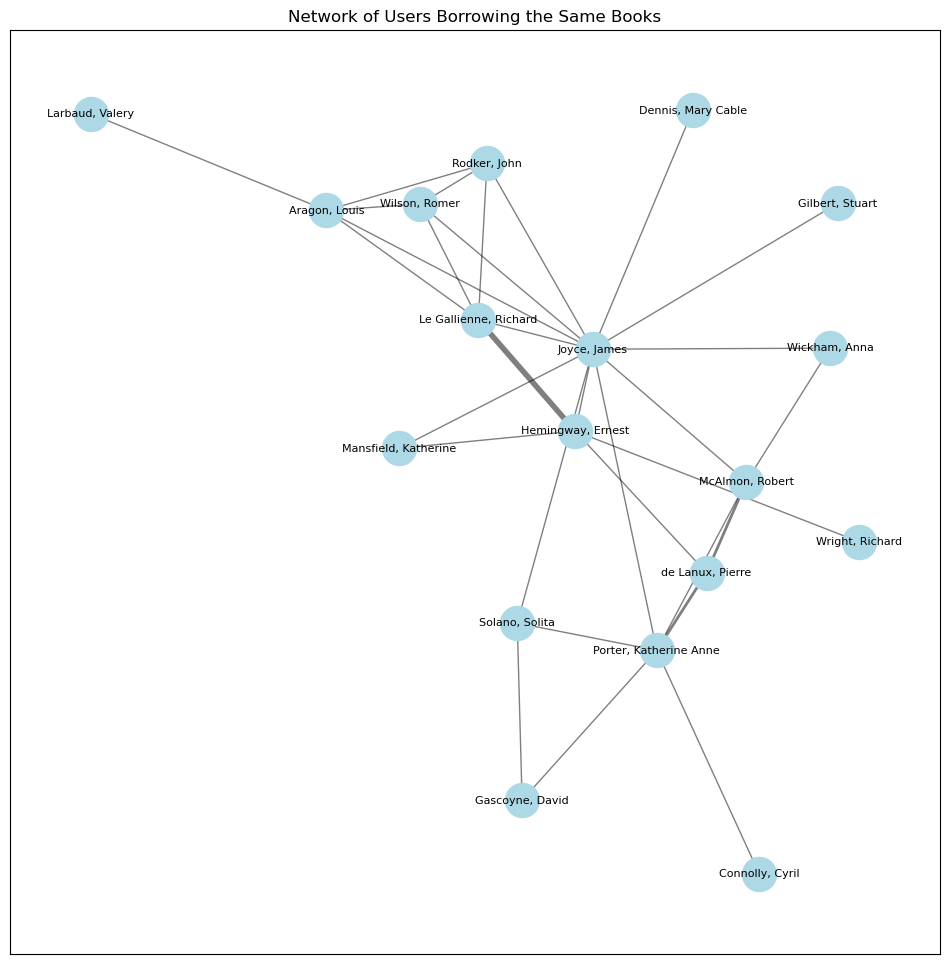

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42, k=0.2, iterations=25)  # Positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u,v in G.edges()], alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Network of Users Borrowing the Same Books')
plt.show()

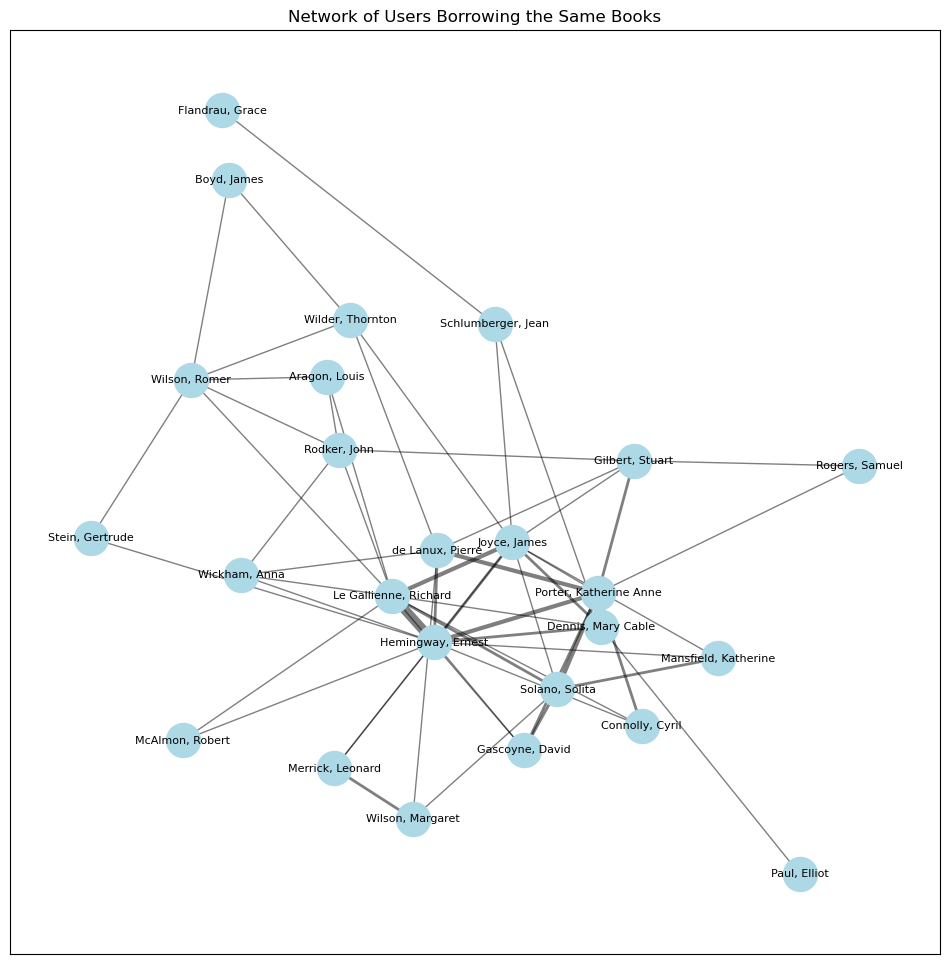

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(L, seed=42, k=0.2, iterations=25)  # Positions for all nodes
nx.draw_networkx_nodes(L, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(L, pos, width=[L[u][v]['weight'] for u,v in L.edges()], alpha=0.5)
nx.draw_networkx_labels(L, pos, font_size=8)
plt.title('Network of Users Borrowing the Same Books')
plt.show()

In [ ]:
# Replace 'member1' and 'member2' with the actual names of the members you're interested in
member1 = 'Hemingway, Ernest'
member2 = 'Le Gallienne, Richard'

# Select the rows for the two members
member1_borrowed = user_book_matrix.loc[member1]
member2_borrowed = user_book_matrix.loc[member2]

# Find the books both members have borrowed
common_books = (member1_borrowed > 0) & (member2_borrowed > 0)

# Output the common books with their borrow counts for both members
common_books_counts = user_book_matrix.loc[[member1, member2], common_books]

print("Books borrowed by both", member1, "and", member2, ":")
common_books_counts

Books borrowed by both Hemingway, Ernest and Le Gallienne, Richard :


item_title,A Farewell to Arms,A Mirror to France,Strait Is the Gate,The Sun Also Rises
member_sort_names,,,,
"Hemingway, Ernest",1,1,1,2
"Le Gallienne, Richard",1,1,1,1


In [ ]:
# Replace 'member1' and 'member2' with the actual names of the members you're interested in
member1 = 'Porter, Katherine Anne'
member2 = 'de Lanux, Pierre'

# Select the rows for the two members
member1_borrowed = user_book_matrix.loc[member1]
member2_borrowed = user_book_matrix.loc[member2]

# Find the books both members have borrowed
common_books = (member1_borrowed > 0) & (member2_borrowed > 0)

# Output the common books with their borrow counts for both members
common_books_counts = user_book_matrix.loc[[member1, member2], common_books]

print("Books borrowed by both", member1, "and", member2, ":")
common_books_counts

Books borrowed by both Porter, Katherine Anne and de Lanux, Pierre :


item_title,A Companion Volume,Distinguished Air: Grim Fairy Tales
member_sort_names,,
"Porter, Katherine Anne",1,1
"de Lanux, Pierre",2,1


In [ ]:
# Replace 'member1' and 'member2' with the actual names of the members you're interested in
member1 = 'Larbaud, Valery'
member2 = 'Aragon, Louis'

# Select the rows for the two members
member1_borrowed = user_book_matrix.loc[member1]
member2_borrowed = user_book_matrix.loc[member2]

# Find the books both members have borrowed
common_books = (member1_borrowed > 0) & (member2_borrowed > 0)

# Output the common books with their borrow counts for both members
common_books_counts = user_book_matrix.loc[[member1, member2], common_books]

print("Books borrowed by both", member1, "and", member2, ":")
common_books_counts

Books borrowed by both Larbaud, Valery and Aragon, Louis :


item_title,Exiles
member_sort_names,
"Larbaud, Valery",1
"Aragon, Louis",1


In [ ]:
# Replace 'member1' and 'member2' with the actual names of the members you're interested in
member1 = 'Joyce, James'

# Select the rows for the member
member1_borrowed = user_book_matrix.loc[member1]

# Find the books both members have borrowed
common_books = (member1_borrowed > 0)

# Output the common books with their borrow counts for both members
common_books_counts = user_book_matrix.loc[[member1], common_books]

print("Books borrowed by both", member1,":")
common_books_counts

Books borrowed by both Joyce, James :


item_title,A Portrait of the Artist as a Young Man,Anna Livia Plurabelle,Back to Montparnasse: Glimpses of Broadway in Bohemia,Castle Conquer,Chamber Music,Dubliners,Echo's Bones and Other Precipitates,Haveth Childers Everywhere: Fragment of Work in Progress,More Pricks Than Kicks,My Thirty Years' War,...,Poems,Pomes Penyeach,The ABC of Economics,The Good Soldier,"The Mime of Mick, Nick, and the Maggies",Three Lives,To Return to Yesterday: Reminiscences 1894 – 1914,Ulysse,Ulysses,Work in Progress
member_sort_names,,,,,,,,,,,,,,,,,,,,,
"Joyce, James",2,3,1,1,2,1,1,1,2,1,...,1,1,2,1,7,1,1,1,1,1


In [ ]:
# Replace 'member1' and 'member2' with the actual names of the members you're interested in
member1 = 'Hemingway, Ernest'
member2 = 'Joyce, James'

# Select the rows for the two members
member1_borrowed = user_book_matrix.loc[member1]
member2_borrowed = user_book_matrix.loc[member2]

# Find the books both members have borrowed
common_books = (member1_borrowed > 0) & (member2_borrowed > 0)

# Output the common books with their borrow counts for both members
common_books_counts = user_book_matrix.loc[[member1, member2], common_books]

print("Books borrowed by both", member1, "and", member2, ":")
common_books_counts

Books borrowed by both Hemingway, Ernest and Joyce, James :


item_title,Three Lives
member_sort_names,
"Hemingway, Ernest",1
"Joyce, James",1


In [ ]:
edge_weights = nx.get_edge_attributes(G,'weight')

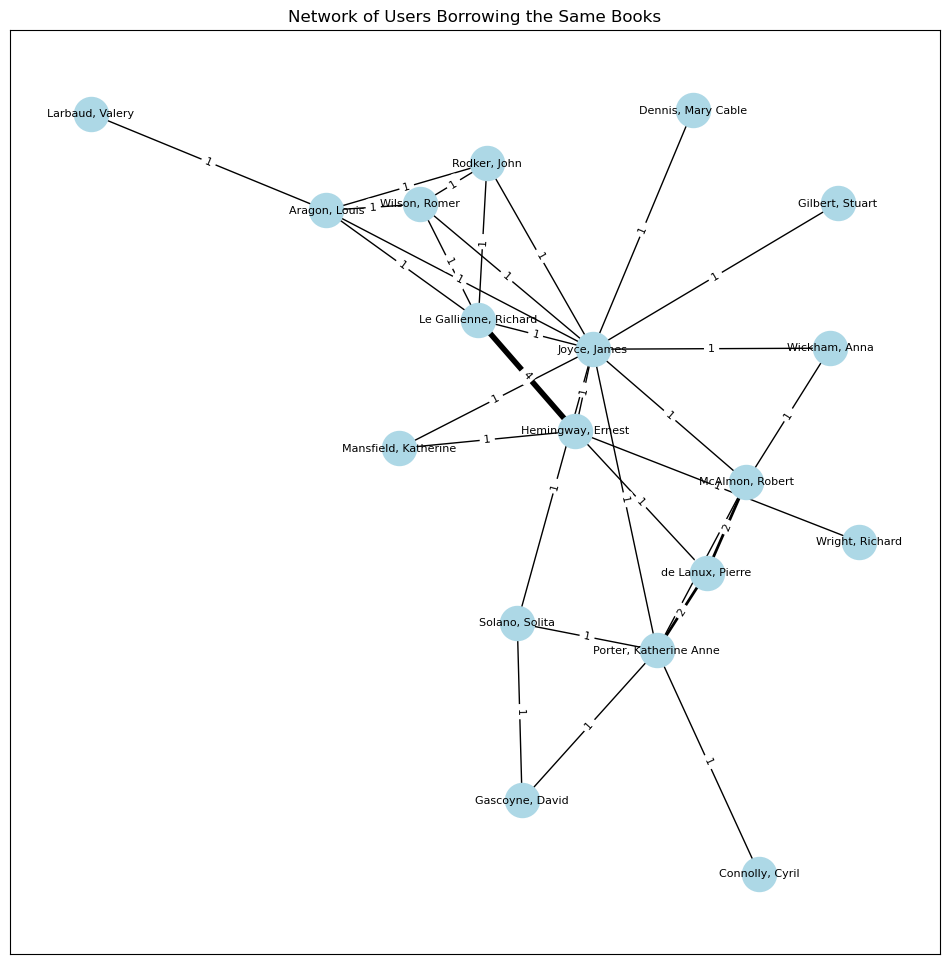

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42, k=0.2, iterations=25)  # Positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=list(edge_weights.values()))
nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_weights, font_size=8)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Network of Users Borrowing the Same Books')
plt.show()

In [ ]:
edge_weights = nx.get_edge_attributes(L,'weight')

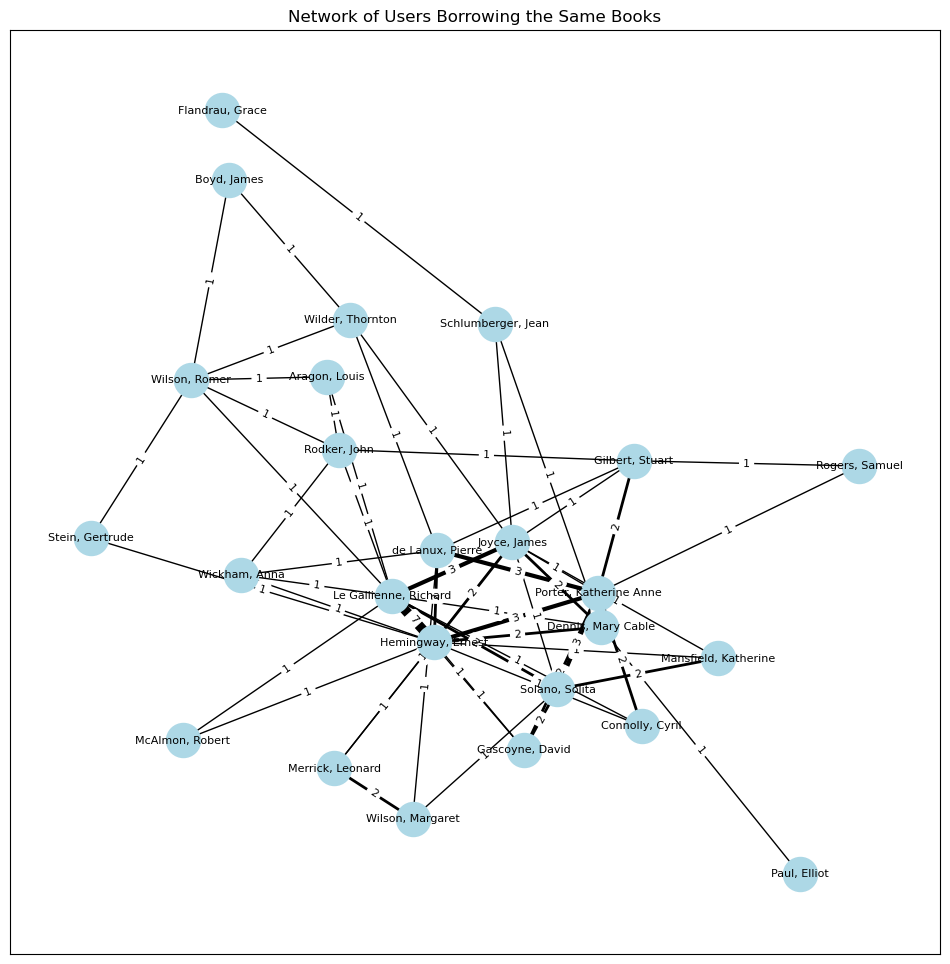

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(L, seed=42, k=0.2, iterations=25)  # Positions for all nodes
nx.draw_networkx_nodes(L, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(L, pos, width=list(edge_weights.values()))
nx.draw_networkx_edge_labels(L, pos,edge_labels=edge_weights, font_size=8)
nx.draw_networkx_labels(L, pos, font_size=8)
plt.title('Network of Users Borrowing the Same Books')
plt.show()

In [ ]:
#nx.degree(G)
#G.degree()
dict(G.degree())

{'Aragon, Louis': 5,
 'Joyce, James': 12,
 'Larbaud, Valery': 1,
 'Le Gallienne, Richard': 5,
 'Rodker, John': 4,
 'Wilson, Romer': 4,
 'Connolly, Cyril': 1,
 'Porter, Katherine Anne': 6,
 'Dennis, Mary Cable': 1,
 'Gascoyne, David': 2,
 'Solano, Solita': 3,
 'Gilbert, Stuart': 1,
 'Hemingway, Ernest': 5,
 'Mansfield, Katherine': 2,
 'Wright, Richard': 1,
 'de Lanux, Pierre': 3,
 'McAlmon, Robert': 4,
 'Wickham, Anna': 2}

These values represent the number of connections each individual has with other individuals, disregarding the intensity or frequency of those connections. It simply counts how many other individuals each person shares at least one book with.
For example, Ernest Hemingway has borrowed books that at least 12 other individuals in the network have also borrowed.

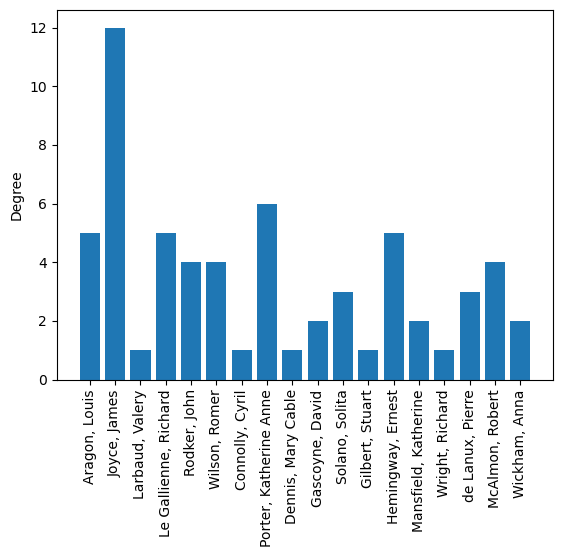

In [ ]:
plt.bar(range(len(dict(G.degree()))), list(dict(G.degree()).values()), align='center')
plt.xticks(range(len(dict(G.degree()))), list(dict(G.degree()).keys()))
plt.xticks(rotation=90)
plt.ylabel('Degree')
plt.show()

The edges do not only indicate that two people have borrowed at least one book in common but also show how many books they share, giving a richer insight into the depth of their common interests.

In [ ]:
dict(G.degree(weight='weight'))

{'Aragon, Louis': 5,
 'Joyce, James': 12,
 'Larbaud, Valery': 1,
 'Le Gallienne, Richard': 8,
 'Rodker, John': 4,
 'Wilson, Romer': 4,
 'Connolly, Cyril': 1,
 'Porter, Katherine Anne': 7,
 'Dennis, Mary Cable': 1,
 'Gascoyne, David': 2,
 'Solano, Solita': 3,
 'Gilbert, Stuart': 1,
 'Hemingway, Ernest': 8,
 'Mansfield, Katherine': 2,
 'Wright, Richard': 1,
 'de Lanux, Pierre': 5,
 'McAlmon, Robert': 5,
 'Wickham, Anna': 2}

Individuals like Le Gallienne, Richard show a significant increase from unweighted to weighted degrees, suggesting that although the number of people he connects with is moderately high, the relationships involve multiple shared books. Conversely, individuals with high unweighted but relatively low weighted degrees might indicate broader but shallower connections.

High values in both metrics, as seen with Hemingway, Ernest, suggest a central figure in the network, likely influencing reading trends or being a core member in their reading community.
ow values in both metrics indicate peripheral figures in the network, potentially with more niche or specialized interests.

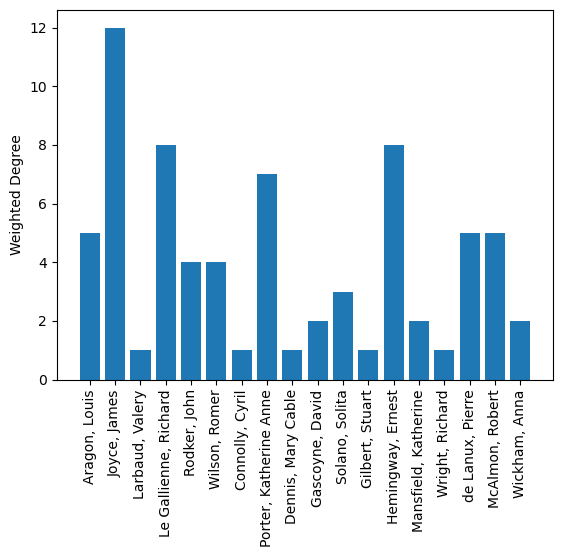

In [ ]:
# weighted degree
plt.bar(range(len(dict(G.degree(weight='weight')))), list(dict(G.degree(weight='weight')).values()), align='center')
plt.xticks(range(len(dict(G.degree(weight='weight')))), list(dict(G.degree(weight='weight')).keys()))
plt.xticks(rotation=90)
plt.ylabel('Weighted Degree')
plt.show()

### Neighbors

In [ ]:
# neighbors of Hemingway, Ernest
list(nx.neighbors(G,'Hemingway, Ernest'))

['Joyce, James',
 'Le Gallienne, Richard',
 'Mansfield, Katherine',
 'Wright, Richard',
 'de Lanux, Pierre']

In [ ]:
# neighbors of Joyce, James
list(nx.neighbors(G,'Joyce, James'))

['Aragon, Louis',
 'Dennis, Mary Cable',
 'Gilbert, Stuart',
 'Hemingway, Ernest',
 'Le Gallienne, Richard',
 'Mansfield, Katherine',
 'McAlmon, Robert',
 'Porter, Katherine Anne',
 'Rodker, John',
 'Solano, Solita',
 'Wickham, Anna',
 'Wilson, Romer']

In [ ]:
# Create subgraph of Hemingway's neighbors
hemingway_neighbors=nx.subgraph(G,list(nx.neighbors(G,'Hemingway, Ernest')))

Hemingway's neighbors and their corresponding node weight

In [ ]:
dict(hemingway_neighbors.degree(weight='weight'))

{'de Lanux, Pierre': 0,
 'Mansfield, Katherine': 1,
 'Wright, Richard': 0,
 'Joyce, James': 2,
 'Le Gallienne, Richard': 1}

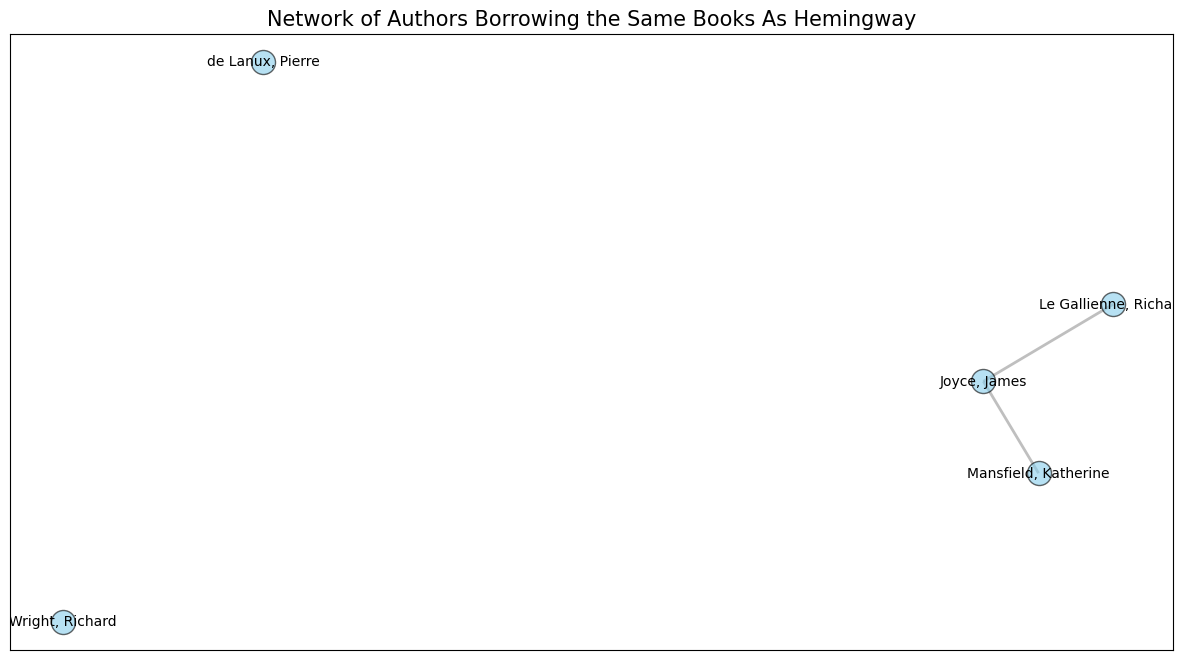

In [ ]:
# Visualization
plt.figure(figsize=(15, 8))

# Using the Kamada-Kawai layout
pos = nx.spring_layout(hemingway_neighbors, weight=None, seed=42, k=0.6)

# Drawing the nodes
nx.draw_networkx_nodes(hemingway_neighbors, pos, node_size=300, node_color='skyblue', alpha=0.6, edgecolors='black')

# Drawing the edges
nx.draw_networkx_edges(hemingway_neighbors, pos, width=2, alpha=0.5, edge_color='gray')

# Drawing the labels
nx.draw_networkx_labels(hemingway_neighbors, pos, font_size=10, font_color='black')

# Add a title
plt.title('Network of Authors Borrowing the Same Books As Hemingway', size=15)

# Show plot
plt.show()

In [ ]:
# Create subgraph of Joyce's neighbors
joyce_neighbors=nx.subgraph(G,list(nx.neighbors(G,'Joyce, James')))

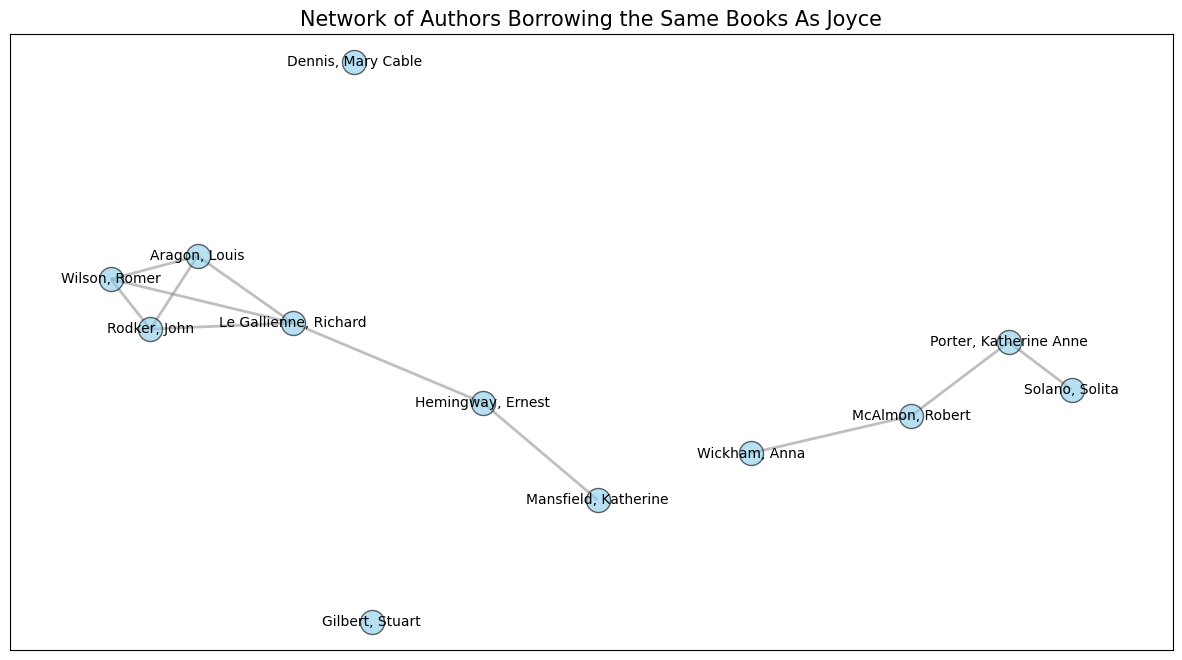

In [ ]:
# Visualization
plt.figure(figsize=(15, 8))

# Using the Kamada-Kawai layout
pos = nx.spring_layout(joyce_neighbors, weight=None, seed=42, k=0.6)

# Drawing the nodes
nx.draw_networkx_nodes(joyce_neighbors, pos, node_size=300, node_color='skyblue', alpha=0.6, edgecolors='black')

# Drawing the edges
nx.draw_networkx_edges(joyce_neighbors, pos, width=2, alpha=0.5, edge_color='gray')

# Drawing the labels
nx.draw_networkx_labels(joyce_neighbors, pos, font_size=10, font_color='black')

# Add a title
plt.title('Network of Authors Borrowing the Same Books As Joyce', size=15)

# Show plot
plt.show()

### Clustering Coefficient

The clustering coefficient is a measure of an "all-my-friends-know-each-other" property. This is sometimes described as the friends of my friends are my friends. More precisely, the clustering coefficient of a node is the ratio of existing links connecting a node's neighbors to each other to the maximum possible number of such links. The clustering coefficient for the entire network is the average of the clustering coefficients of all the nodes. A high clustering coefficient for a network is another indication of a small world.

Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit groups characterised by a relatively high density of ties; this likelihood tends to be greater than the average probability of a tie randomly established between two nodes (Holland and Leinhardt, 1971; Watts and Strogatz, 1998).


Average clustering coefficient of network is about 0.41

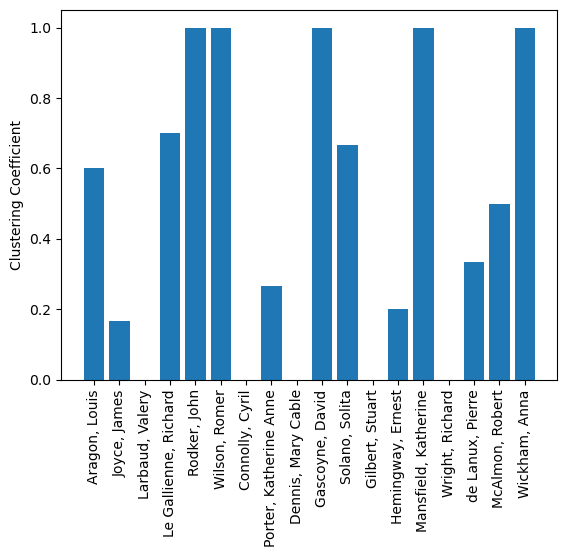

In [ ]:
cluster_coeff=nx.clustering(G)
plt.bar(range(len(cluster_coeff)), list(cluster_coeff.values()), align='center')
plt.xticks(range(len(cluster_coeff)), list(cluster_coeff.keys()))
plt.xticks(rotation=90)
plt.ylabel('Clustering Coefficient')
plt.show()

### Nodes, Edges, Diameter, Density, Average Shortest Path Length

In [ ]:
# number of nodes
# number of members
len(G.nodes())

18

In [ ]:
# number of edges
# number of relationships
len(G.edges())

31

The density of a graph is a measure of how many ties between actors exist compared to how many ties between actors are possible.

In [ ]:
# density
nx.density(G)

0.20261437908496732

In [ ]:
print(2*len(G.edges())/(len(G.nodes())*(len(G.nodes())-1)))

0.20261437908496732


How many possible edges in the network are present? About 19% --> Relatively diverse reading habits

As another means of measuring network graphs, we can define the diameter of a network as the longest of all the calculated shortest paths in a network. It is the shortest distance between the two most distant nodes in the network. In other words, once the shortest path length from every node to all other nodes is calculated, the diameter is the longest of all the calculated path lengths. The diameter is representative of the linear size of a network. If node A-B-C-D are connected, going from A->D this would be the diameter of 3 (3-hops, 3-links)

In [ ]:
# diameter
nx.diameter(G)

4

The average shortest path length is calculated by finding the shortest path between all pairs of nodes, and taking the average over all paths of the length thereof (the length being the number of intermediate edges contained in the path).

Even in the relatively sparse network, members are not too distant from each other, meaning the library community is fairly interconnected.

In [ ]:
# average shortest path length
nx.average_shortest_path_length(G)

2.1372549019607843

Any two nodes in the network can be connected by a little over two steps

### Assortativity and Average Clustering Coefficient

The assortativity coefficient is the Pearson correlation coefficient of degree between pairs of linked nodes. Positive values of r indicate a correlation between nodes of similar degree, while negative values indicate relationships between nodes of different degree. In general, r lies between −1 and 1. When r = 1, the network is said to have perfect assortative mixing patterns, when r = 0 the network is non-assortative, while at r = −1 the network is completely disassortative.

In [ ]:
# assortativity
nx.assortativity.degree_assortativity_coefficient(G)

-0.3522239395500598

Moderately disassortative network: Networks tend to cluster together. It ranges from 0 to 1, where higher values indicate more clustering

The assortativity coefficient of a graph is a measure of the extent to which vertices with the same properties connect to each other.

In [ ]:
# average clustering coefficient
nx.average_clustering(G)

0.46851851851851856

### Small World

In [ ]:
# small worldness is defined as the ratio between average clustering coefficient and average shortest path length,
# relative to an equivalent random graph
print(nx.average_clustering(G)/nx.average_shortest_path_length(G))

0.21921508664627934


In [ ]:
nx.algorithms.smallworld.sigma(G,niter=10,nrand=5)

1.3012460632616734

A sigma value greater than 1 indicates that the network exhibits small-world properties. The given network has higher clustering than a random network but similar path lengths, characteristic of small-world networks.

### Cliques

All nodes in a clique are connected with each other.

Interesting are “maximal cliques”

In [ ]:
clique=list(nx.clique.find_cliques(G))

In [ ]:
len(clique)

14

In [ ]:
clique

[['de Lanux, Pierre', 'Hemingway, Ernest'],
 ['de Lanux, Pierre', 'McAlmon, Robert', 'Porter, Katherine Anne'],
 ['Connolly, Cyril', 'Porter, Katherine Anne'],
 ['Wright, Richard', 'Hemingway, Ernest'],
 ['Gascoyne, David', 'Solano, Solita', 'Porter, Katherine Anne'],
 ['Joyce, James', 'Dennis, Mary Cable'],
 ['Joyce, James', 'Wickham, Anna', 'McAlmon, Robert'],
 ['Joyce, James', 'Solano, Solita', 'Porter, Katherine Anne'],
 ['Joyce, James', 'McAlmon, Robert', 'Porter, Katherine Anne'],
 ['Joyce, James', 'Mansfield, Katherine', 'Hemingway, Ernest'],
 ['Joyce, James',
  'Le Gallienne, Richard',
  'Rodker, John',
  'Aragon, Louis',
  'Wilson, Romer'],
 ['Joyce, James', 'Le Gallienne, Richard', 'Hemingway, Ernest'],
 ['Joyce, James', 'Gilbert, Stuart'],
 ['Larbaud, Valery', 'Aragon, Louis']]

### Communities

“there are more links within a community than to nodes
outside of it”

label_propagation_communities generates community sets determined by label propagation

#### Label propagation

In [ ]:
communities=list(nx.community.label_propagation_communities(G))
communities

[{'Aragon, Louis',
  'Dennis, Mary Cable',
  'Gilbert, Stuart',
  'Hemingway, Ernest',
  'Joyce, James',
  'Larbaud, Valery',
  'Le Gallienne, Richard',
  'Mansfield, Katherine',
  'Rodker, John',
  'Wickham, Anna',
  'Wilson, Romer',
  'Wright, Richard'},
 {'Connolly, Cyril',
  'McAlmon, Robert',
  'Porter, Katherine Anne',
  'de Lanux, Pierre'},
 {'Gascoyne, David', 'Solano, Solita'}]

In [ ]:
node_color_number=[]
for node in G:
    for community in range(len(communities)):
        if str(node) in communities[community]:
            node_color_number.append(community)

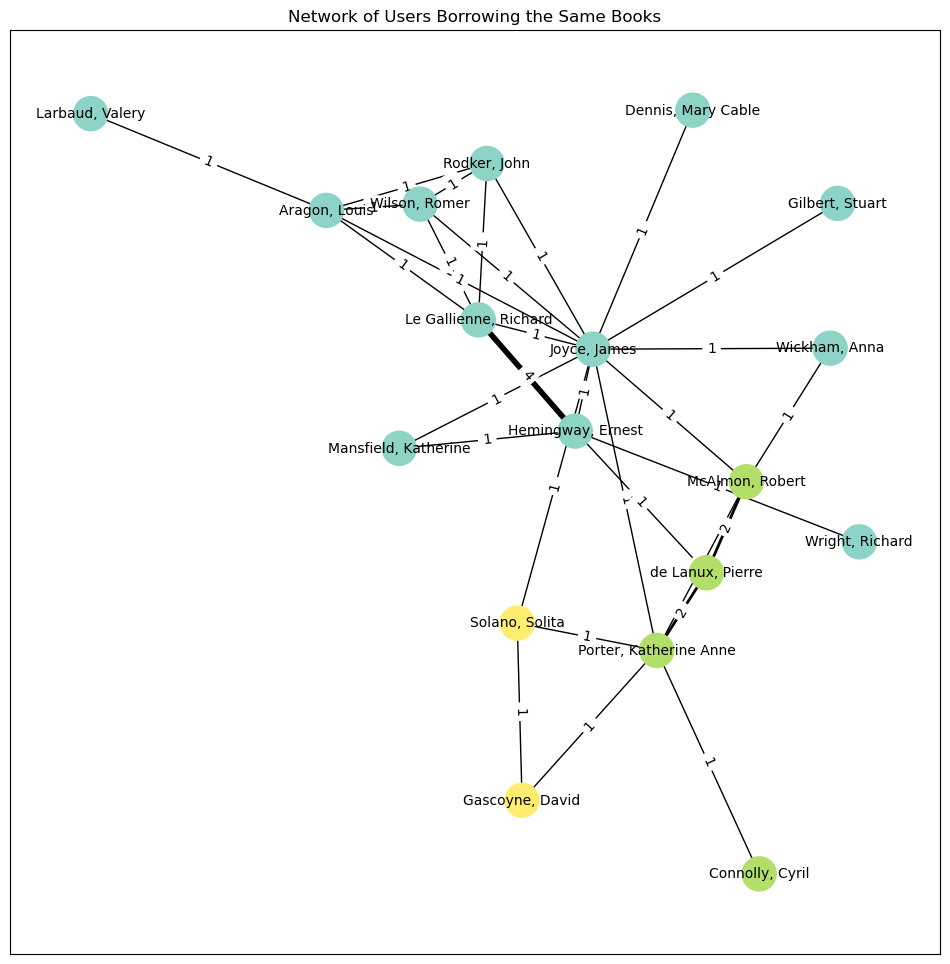

In [ ]:
# Create a figure with a specified size
plt.figure(figsize=(12, 12))

# Generate positions for each node using the spring layout
pos = nx.spring_layout(G, seed=42, k=0.2, iterations=25)

# Draw nodes with a color map
nx.draw_networkx_nodes(G, pos, node_size=600, node_color=node_color_number, cmap=plt.cm.Set3)

# Draw edges and edge labels with specified widths
edge_weights = nx.get_edge_attributes(G, 'weight')  # Ensure edge weights are obtained correctly
nx.draw_networkx_edges(G, pos, width=list(edge_weights.values()))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Set the title of the plot
plt.title('Network of Users Borrowing the Same Books')

# Display the plot
plt.show()

#### Louvain

In [ ]:
communities_louvain = list(nx.community.louvain_communities(G, seed=42))
communities_louvain

[{'Hemingway, Ernest', 'Le Gallienne, Richard', 'Wright, Richard'},
 {'Aragon, Louis', 'Larbaud, Valery', 'Rodker, John', 'Wilson, Romer'},
 {'Dennis, Mary Cable',
  'Gilbert, Stuart',
  'Joyce, James',
  'Mansfield, Katherine'},
 {'Connolly, Cyril',
  'Gascoyne, David',
  'McAlmon, Robert',
  'Porter, Katherine Anne',
  'Solano, Solita',
  'Wickham, Anna',
  'de Lanux, Pierre'}]

In [ ]:
node_color_number_louvain=[]
for node in G:
    for community in range(len(communities_louvain)):
        if str(node) in communities_louvain[community]:
            node_color_number_louvain.append(community)

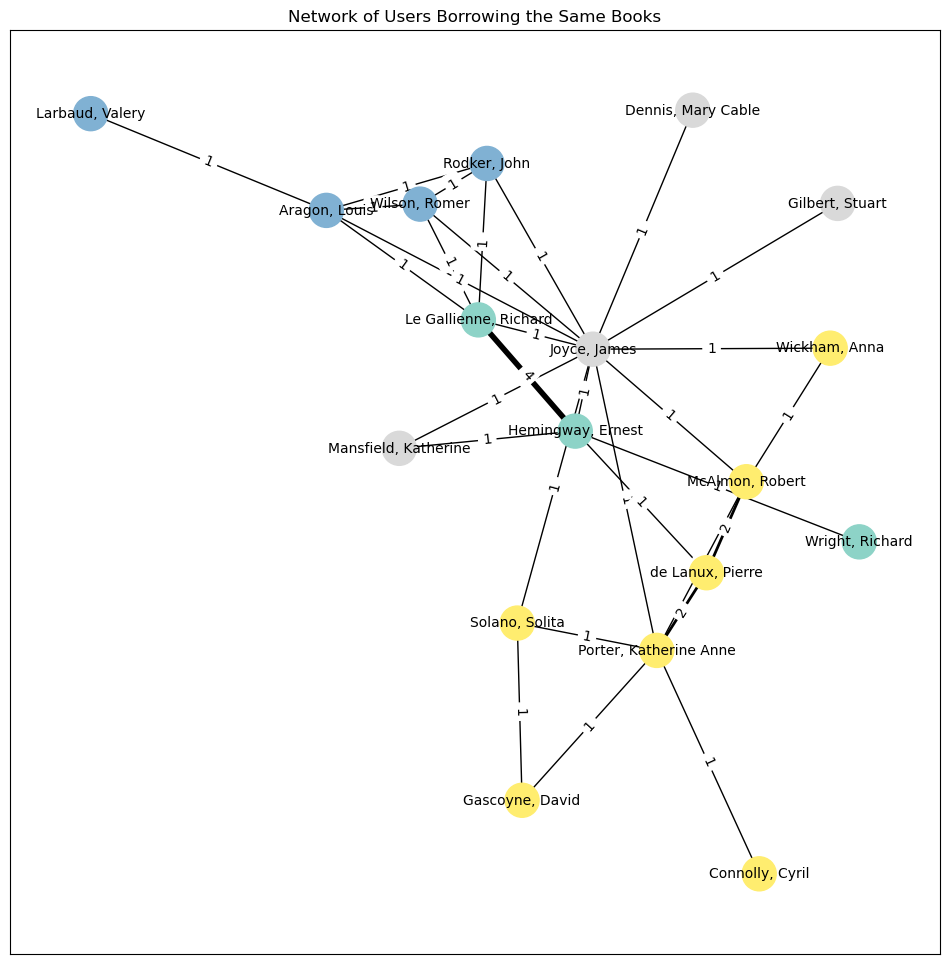

In [ ]:
# Create a figure with a specified size
plt.figure(figsize=(12, 12))

# Generate positions for each node using the spring layout
pos = nx.spring_layout(G, seed=42, k=0.2, iterations=25)

# Draw nodes with a color map
nx.draw_networkx_nodes(G, pos, node_size=600, node_color=node_color_number_louvain, cmap=plt.cm.Set3)

# Draw edges and edge labels with specified widths
edge_weights = nx.get_edge_attributes(G, 'weight')  # Ensure edge weights are obtained correctly
nx.draw_networkx_edges(G, pos, width=list(edge_weights.values()))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Set the title of the plot
plt.title('Network of Users Borrowing the Same Books')

# Display the plot
plt.show()

In [ ]:
# Replace 'member1' and 'member2' with the actual names of the members you're interested in
member1 = 'Porter, Katherine Anne'
member2 = 'de Lanux, Pierre'
member3 = 'McAlmon, Robert'

# Select the rows for the two members
member1_borrowed = user_book_matrix.loc[member1]
member2_borrowed = user_book_matrix.loc[member2]
member3_borrowed = user_book_matrix.loc[member3]

# Find the books both members have borrowed
common_books = (member1_borrowed > 0) & (member2_borrowed > 0) & (member3_borrowed > 0)

# Output the common books with their borrow counts for both members
common_books_counts = user_book_matrix.loc[[member1, member2, member3], common_books]

print("Books borrowed by both", member1, "and", member2, "and", member3, ":")
common_books_counts

Books borrowed by both Porter, Katherine Anne and de Lanux, Pierre and McAlmon, Robert :


item_title,Distinguished Air: Grim Fairy Tales
member_sort_names,
"Porter, Katherine Anne",1
"de Lanux, Pierre",1
"McAlmon, Robert",1


In [ ]:
# Replace 'member1' and 'member2' with the actual names of the members you're interested in
member1 = 'Joyce, James'
member2 = 'Hemingway, Ernest'
member3 = 'Mansfield, Katherine'

# Select the rows for the two members
member1_borrowed = user_book_matrix.loc[member1]
member2_borrowed = user_book_matrix.loc[member2]
member3_borrowed = user_book_matrix.loc[member3]

# Find the books both members have borrowed
common_books = (member1_borrowed > 0) & (member2_borrowed > 0) & (member3_borrowed > 0)

# Output the common books with their borrow counts for both members
common_books_counts = user_book_matrix.loc[[member1, member2, member3], common_books]

print("Books borrowed by both", member1, "and", member2, "and", member3, ":")
common_books_counts

Books borrowed by both Joyce, James and Hemingway, Ernest and Mansfield, Katherine :


item_title,Three Lives
member_sort_names,
"Joyce, James",1
"Hemingway, Ernest",1
"Mansfield, Katherine",1


#### Greedy Modularity

In [ ]:
communities_greedy = list(nx.community.greedy_modularity_communities(G))
communities_greedy

[frozenset({'Aragon, Louis',
            'Larbaud, Valery',
            'Le Gallienne, Richard',
            'Rodker, John',
            'Wilson, Romer'}),
 frozenset({'Dennis, Mary Cable',
            'Gilbert, Stuart',
            'Joyce, James',
            'McAlmon, Robert',
            'Wickham, Anna'}),
 frozenset({'Connolly, Cyril',
            'Gascoyne, David',
            'Porter, Katherine Anne',
            'Solano, Solita'}),
 frozenset({'Hemingway, Ernest',
            'Mansfield, Katherine',
            'Wright, Richard',
            'de Lanux, Pierre'})]

In [ ]:
node_color_number_greedy=[]
for node in G:
    for community in range(len(communities_greedy)):
        if str(node) in communities_greedy[community]:
            node_color_number_greedy.append(community)

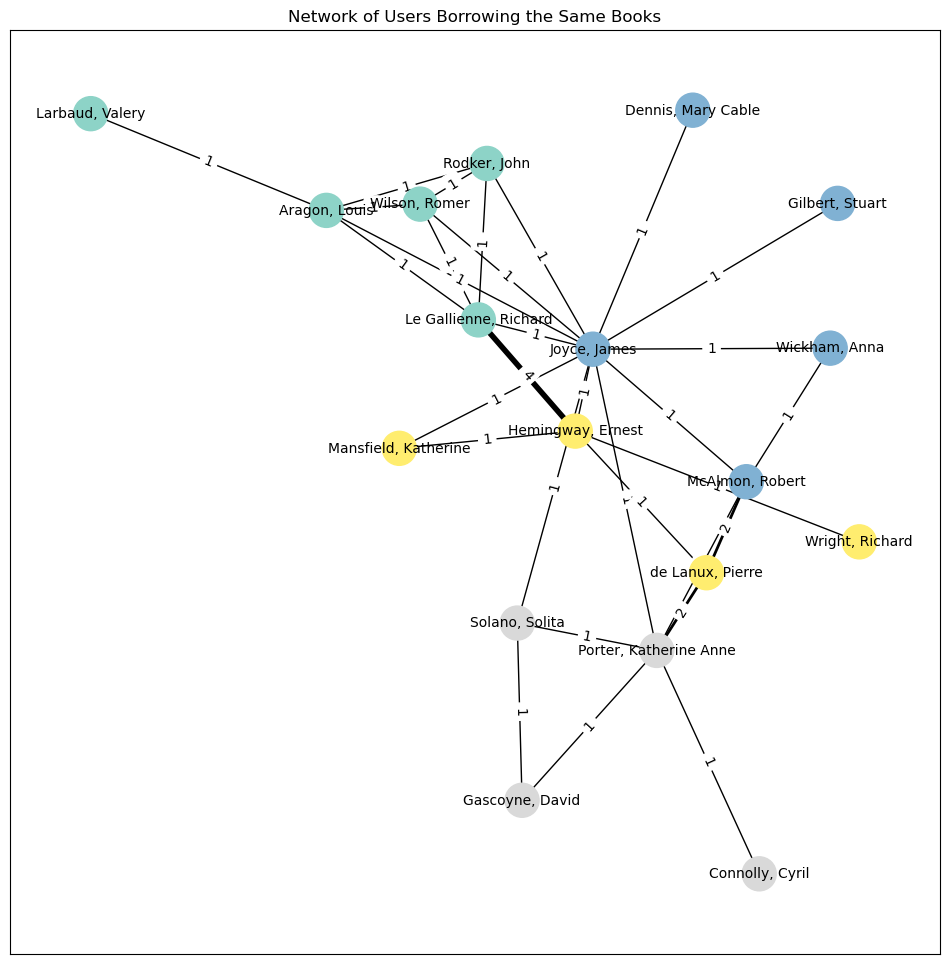

In [ ]:
# Create a figure with a specified size
plt.figure(figsize=(12, 12))

# Generate positions for each node using the spring layout
pos = nx.spring_layout(G, seed=42, k=0.2, iterations=25)

# Draw nodes with a color map
nx.draw_networkx_nodes(G, pos, node_size=600, node_color=node_color_number_greedy, cmap=plt.cm.Set3)

# Draw edges and edge labels with specified widths
edge_weights = nx.get_edge_attributes(G, 'weight')  # Ensure edge weights are obtained correctly
nx.draw_networkx_edges(G, pos, width=list(edge_weights.values()))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Set the title of the plot
plt.title('Network of Users Borrowing the Same Books')

# Display the plot
plt.show()

#### Girvan Newman

In [ ]:
# Generate the community structure using Girvan-Newman algorithm
comp = girvan_newman(G)
limited = next(comp)  # Get the first set of communities

# Convert to list for easy inspection
communities_gn = [list(c) for c in limited]
print("Communities found using Girvan-Newman:", communities_gn)

Communities found using Girvan-Newman: [['Rodker, John', 'Dennis, Mary Cable', 'Hemingway, Ernest', 'Mansfield, Katherine', 'Gilbert, Stuart', 'Wright, Richard', 'Joyce, James', 'Wilson, Romer', 'Le Gallienne, Richard', 'Aragon, Louis', 'Larbaud, Valery'], ['Solano, Solita', 'Wickham, Anna', 'de Lanux, Pierre', 'Connolly, Cyril', 'McAlmon, Robert', 'Gascoyne, David', 'Porter, Katherine Anne']]


In [ ]:
node_color_number_gn=[]
for node in G:
    for community in range(len(communities_gn)):
        if str(node) in communities_gn[community]:
            node_color_number_gn.append(community)

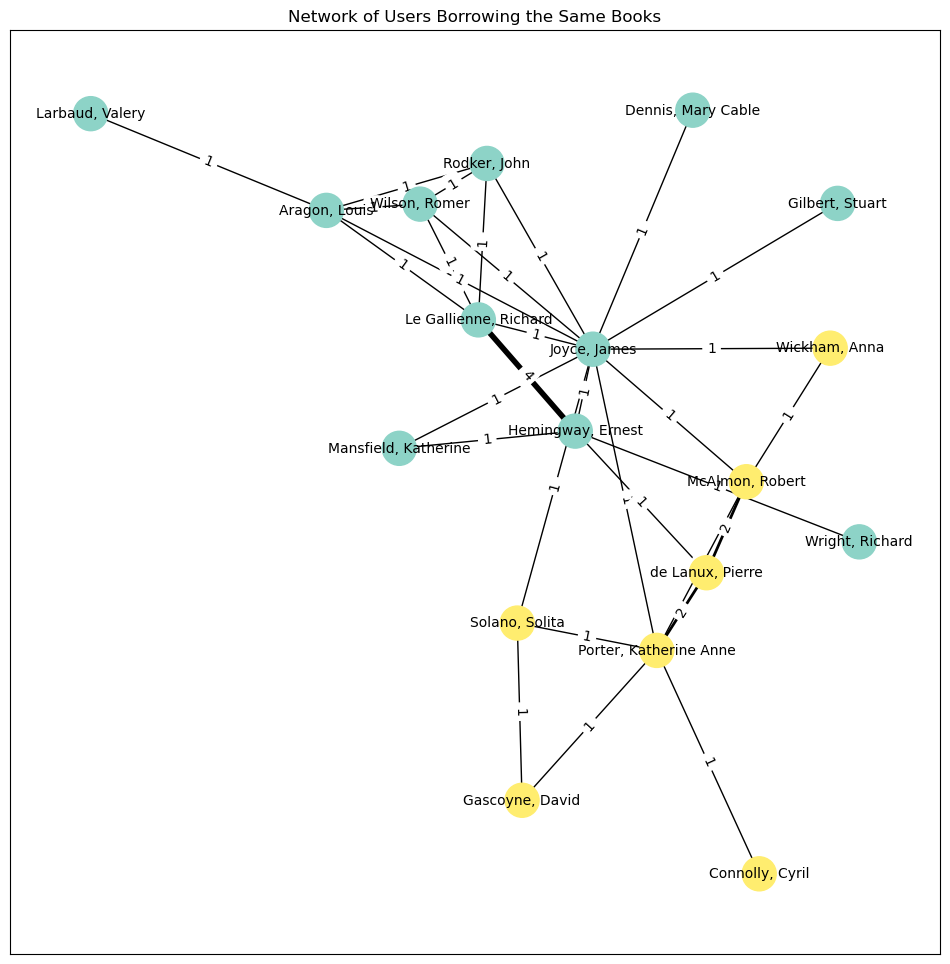

In [ ]:
# Create a figure with a specified size
plt.figure(figsize=(12, 12))

# Generate positions for each node using the spring layout
pos = nx.spring_layout(G, seed=42, k=0.2, iterations=25)

# Draw nodes with a color map
nx.draw_networkx_nodes(G, pos, node_size=600, node_color=node_color_number_gn, cmap=plt.cm.Set3)

# Draw edges and edge labels with specified widths
edge_weights = nx.get_edge_attributes(G, 'weight')  # Ensure edge weights are obtained correctly
nx.draw_networkx_edges(G, pos, width=list(edge_weights.values()))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Set the title of the plot
plt.title('Network of Users Borrowing the Same Books')

# Display the plot
plt.show()

### Network of Titles and Members

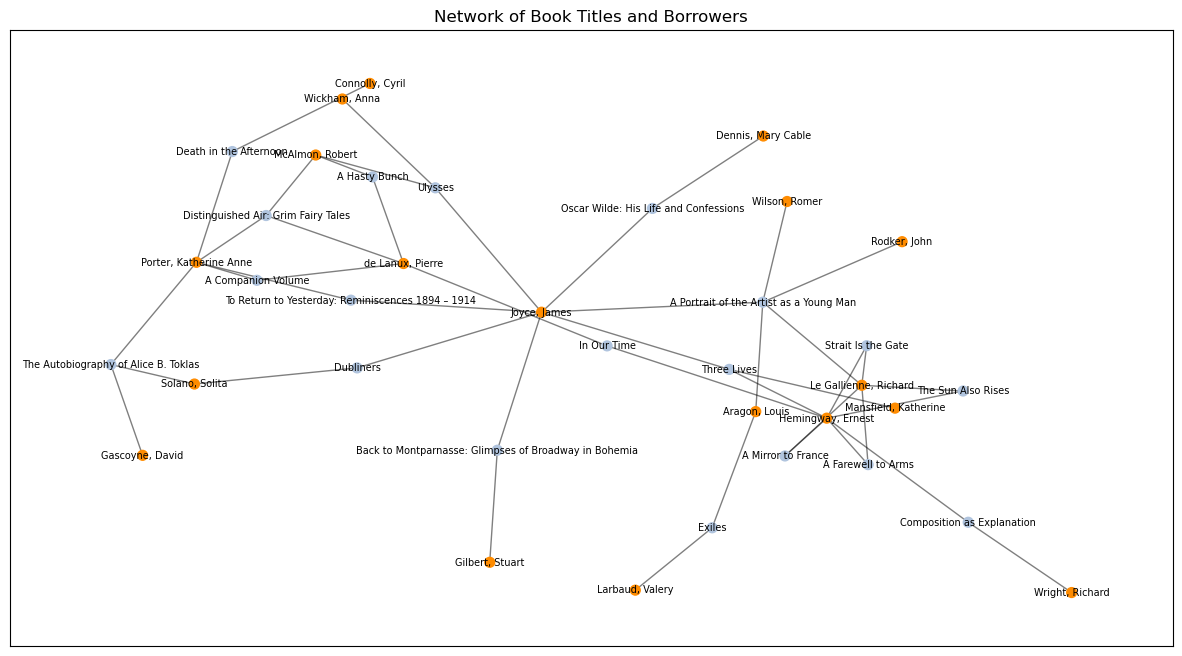

In [ ]:
# Convert pivot table to edge list
edge_list = user_book_matrix.stack().reset_index()
edge_list.columns = ['member_sort_names', 'item_title', 'borrowed']
edge_list = edge_list[edge_list['borrowed'] > 0]

# Filter books that were only borrowed once overall
book_counts = edge_list['item_title'].value_counts()
books_multi_borrowed = book_counts[book_counts > 1].index
edge_list = edge_list[edge_list['item_title'].isin(books_multi_borrowed)]

# Create a graph from the edge list
G_T = nx.from_pandas_edgelist(edge_list, source='item_title', target='member_sort_names', create_using=nx.Graph())

# Visualization
plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G_T,  seed=42, k=0.2, iterations=25)  # Positions for all nodes
#0.3
#0.6

# Assign colors to nodes
node_colors = ['lightsteelblue' if node in edge_list['item_title'].unique() else 'darkorange' for node in G_T]

# Draw nodes and edges with the assigned colors
nx.draw_networkx_nodes(G_T, pos, node_color=node_colors, node_size=50)
nx.draw_networkx_edges(G_T, pos, alpha=0.5)
nx.draw_networkx_labels(G_T, pos, font_size=7)

plt.title('Network of Book Titles and Borrowers')
plt.show()

#### similar to https://viz.shakespeareandco.princeton.edu/2024/woolf-common-readers/